In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/word2vec/__results__.html
/kaggle/input/word2vec/__notebook__.ipynb
/kaggle/input/word2vec/__output__.json
/kaggle/input/word2vec/custom.css
/kaggle/input/word2vec/output/finetuned.txt
/kaggle/input/word2vec/scratch/scratch.txt
/kaggle/input/pretrained-fasttext/lstm_prev.py
/kaggle/input/pretrained-fasttext/model_utils.py
/kaggle/input/pretrained-fasttext/lstm.py
/kaggle/input/pretrained-fasttext/pretrained_word2vec/pretrained_word2vec.txt
/kaggle/input/pretrained-fasttext/pretrained_fasttext/pretrained_fasttext/pretrained.fast_text.wv.vectors_vocab.npy
/kaggle/input/pretrained-fasttext/pretrained_fasttext/pretrained_fasttext/pretrained.fast_text.trainables.vectors_ngrams_lockf.npy
/kaggle/input/pretrained-fasttext/pretrained_fasttext/pretrained_fasttext/pretrained.fast_text.wv.vectors.npy
/kaggle/input/pretrained-fasttext/pretrained_fasttext/pretrained_fasttext/pretrained.fast_text.trainables.syn1neg.npy
/kaggle/input/pretrained-fasttext/pretrained_fasttext/pretrained_fa

# Word2vec models CV
## Loading fasttext and dataset

In [2]:
!pip install -q mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.3/95.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import precision_score,confusion_matrix, precision_recall_curve, classification_report, average_precision_score, ConfusionMatrixDisplay, matthews_corrcoef, f1_score
from pathlib import Path
import shutil, random, copy, multiprocessing
import mlflow

# Custom Dataset function
Path("./custom_dataset").mkdir()
shutil.copy(Path("/kaggle/input/nephased-datasets/torch_datasets/datasets.py"), Path("./custom_dataset/"))
from custom_dataset.datasets import SequenceDataset

# Residual LSTM implementation
shutil.copy(Path("/kaggle/input/pretrained-fasttext/lstm.py"), Path("./"))
from lstm import ResLSTM

# Utitilites for cross validation
shutil.copy(Path("/kaggle/input/pretrained-fasttext/model_utils.py"), Path("./"))
from model_utils import (
    model_train, evaluate_model, 
    DNN_Classifier, BiLSTMAttn, BiLSTMAttn2, 
    DNNModifiedDataset, ModifiedDataset, # Custom Datasets for DNN model and BiLSTMAttn2 model
    run_cross_validation
)

# Embedding model path
word2vec_path = "/kaggle/input/word2vec/output/finetuned.txt"

For ease of use, training function and model class definitions are imported as python module. They are tested in earlier prototypes. 

## Setting Seed for reproducibility

In [4]:
def set_seed(seed=42):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)                      # Python random
    np.random.seed(seed)                   # NumPy
    torch.manual_seed(seed)                # PyTorch CPU
    torch.cuda.manual_seed(seed)           # PyTorch CUDA
    torch.cuda.manual_seed_all(seed)       # All GPUs
    torch.backends.cudnn.deterministic = True  # Force deterministic ops
    torch.backends.cudnn.benchmark = False     # Disable auto benchmark

set_seed(42)

In [5]:
# Loading the embedder
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=False)

print(word2vec["ठोक"])

[ 4.74555850e-01  3.54676396e-02 -2.08788857e-01  1.70470998e-01
 -1.18067317e-01  9.29699302e-01 -7.04040453e-02  8.03592801e-01
 -1.27339840e-01 -4.58929420e-01 -3.97410877e-02 -1.26310542e-01
  1.22885859e+00 -2.62806565e-01  5.53501725e-01  1.81062296e-01
 -2.07190886e-01 -7.13008463e-01  1.14000868e-02 -4.11830097e-01
  7.88021564e-01 -1.51249900e-01  3.57702732e-01 -5.45188546e-01
 -4.65510398e-01  5.79088688e-01 -3.39206010e-01 -6.03623629e-01
 -6.29097939e-01 -4.84275103e-01 -4.23519649e-02  1.93168029e-01
 -1.95928156e-01  2.76344717e-02 -3.22212100e-01  6.57154799e-01
 -5.20747662e-01  7.15428650e-01  2.54623979e-01  7.48650551e-01
 -1.47100151e-01 -3.59026686e-04  5.79743922e-01  1.53442368e-01
  5.20630896e-01  2.46685699e-01  1.72282055e-01  8.39064866e-02
  2.88603872e-01 -7.53973067e-01  1.94269344e-01 -5.50153613e-01
  7.15422444e-03 -4.11128074e-01 -8.50513279e-01 -5.57424545e-01
  5.80618441e-01 -1.10639557e-01 -2.66360968e-01  4.20838654e-01
  5.66144228e-01  2.79027

In [6]:
# Getting the Dataset
train = torch.load("/kaggle/input/nephased-datasets/torch_datasets/train.pt")
test = torch.load("/kaggle/input/nephased-datasets/torch_datasets/test.pt")
val = torch.load("/kaggle/input/nephased-datasets/torch_datasets/val.pt")

print(len(train["sentences"]))
print(test["sentences"][0])
print(len(test["labels"]))

3765
['गोलि', 'हान्यो', 'तिर्थ', 'लाइ', 'प्रहरी', 'चोर', 'होश', 'प्रबक्ता', '।']
471


In [7]:
# Adding pad token to word2vec
PAD_TOKEN = "<pad>"

# In W2V models' text file
def add_pad_to_word2vec_model(model, pad_token="<pad>"):
    if pad_token not in model.key_to_index:
        model.add_vector(pad_token, np.zeros(model.vector_size))

add_pad_to_word2vec_model(word2vec)

/usr/local/lib/python3.11/dist-packages/gensim/models/keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(


## Transforming text to vectors with our custom torch dataset class


In [8]:
# Using custom dataset to get vectors for our tokens
finetuned_train = SequenceDataset(train["sentences"], binary=False, model=word2vec, labels=train["labels"])
finetuned_test = SequenceDataset(test["sentences"], binary=False, model=word2vec, labels=test["labels"])
finetuned_val = SequenceDataset(val["sentences"], binary=False, model=word2vec, labels=val["labels"])

dataset = ConcatDataset([finetuned_train, finetuned_test, finetuned_val])

we map labels to general, light_profanity, high_profanity and violence

In [9]:
# label map int to string
label_map = {
    0: 'GENERAL',
    1: 'LIGHT_PROFANITY',
    2: 'HIGH_PROFANITY',
    3: 'VIOLENCE'
}

num_classes= 4

In [10]:
class LabelModifiedDataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset
        self.label_mapping = {
            0: 0,
            1: 0,
            2: 1,
            3: 2,
            4: 3,
            5: 3
        }
    
    def __len__(self):
        return len(self.original_dataset)
    
    def __getitem__(self, idx):
        item = self.original_dataset[idx]
        
        features, mask, label = item
        
        # Apply the specific mapping rules
        original_label = label.item()
        new_label = self.label_mapping.get(original_label, original_label)      
        
        return (features, mask, torch.tensor(new_label, dtype=label.dtype))

dataset = LabelModifiedDataset(dataset)

In [11]:
print(dataset[0])
print(dataset[0][0])

(tensor([[ 1.4051, -0.7287, -4.7587,  ...,  0.4785, -1.0731,  0.4346],
        [-2.5477, -0.8704,  3.0469,  ...,  2.9518,  2.7322,  1.9727],
        [ 0.6623, -0.4788, -1.4086,  ..., -0.5638,  0.0130,  0.1515],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]), tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, Fal

/kaggle/working/custom_dataset/datasets.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  torch.tensor(vectors, dtype=torch.float32),


In [12]:
print(dataset[0][0].shape)

torch.Size([100, 300])


In [13]:
print(len(dataset))

4707


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

sequence_length, embeddings_size= dataset[0][0].shape
print(sequence_length)
print(embeddings_size)

Using device: cpu
100
300


## Models and Parameters

In [15]:
architectures_to_test = [
    {
        "name": "WordVec_BiLSTM2",
        "model_class": BiLSTMAttn2,
        "params": {
            "input_dim": embeddings_size, "hidden_dim": 128, "num_classes": num_classes,
            "num_layers": 1, "dropout": 0.5, "bidirectional": True,
            "lr": 3e-5, "weight_decay": 0.003, "label_smoothing": 0.05,
            "train_batch": 8, "val_batch": 8, "epochs": 20, "patience": 3, "early_stopping": False,
            "warmup_ratio" : 0.2
        },
        "dataset_wrapper": ModifiedDataset,
        "is_dnn": False,
        "is_model2": True,
        "scheduler": "linear_warmup",
    },
    {
        "name": "WordVec_BiLSTM",
        "model_class": BiLSTMAttn,
        "params": {
            "input_dim": embeddings_size, "hidden_dim": 128, "num_classes": num_classes,
            "num_layers": 1, "dropout": 0.5, "bidirectional": True,
            "lr": 3e-5, "weight_decay": 0.003, "label_smoothing": 0.05,
            "train_batch": 8, "val_batch": 8, "epochs": 20, "patience": 3, "early_stopping": False,
            "warmup_ratio": 0.2
        },
        "dataset_wrapper": None,
        "is_dnn": False,
        "is_model2": False,
        "scheduler": "linear_warmup", 
    },
    {
        "name": "WordVec_DNN",
        "model_class": DNN_Classifier,
        "params": {
            "input_dim": embeddings_size, "output_dim": num_classes, # DNN specific params
            "input_neurons": 64, "hidden_neurons": 32, "input_dropout": 0.3, "hidden_dropout": 0.4,
            "lr": 0.0001, "label_smoothing": 0,
            "train_batch": 8, "val_batch": 8, "epochs": 60, "patience": 3, "early_stopping": False,
        },
        "dataset_wrapper": DNNModifiedDataset,
        "is_dnn": True,
        "is_model2": False,
        "scheduler": None,
    },
    {
        "name": "WordVec_BiLSTM_residual",
        "model_class": BiLSTMAttn,
        "params": {
            "input_dim": embeddings_size, "hidden_dim": 128, "num_classes": num_classes,
            "num_layers": 1, "dropout": 0.5, "bidirectional": True,
            "lr": 3e-5, "weight_decay": 0.003, "label_smoothing": 0.05,
            "train_batch": 8, "val_batch": 8, "epochs": 20, "patience": 3, "early_stopping": False,
            "warmup_ratio": 0.2, "residual": True
        },
        "dataset_wrapper": None,
        "is_dnn": False,
        "is_model2": False,
        "scheduler": "linear_warmup", 
    },
]

## MLFLOW initialization

In [16]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("dagshub")

os.environ["MLFLOW_TRACKING_USERNAME"] = "tamangangel2057"
os.environ["MLFLOW_TRACKING_PASSWORD"] = secret_value_0  

# Initialize MLflow tracking
mlflow.set_tracking_uri("https://dagshub.com/tamangangel2057/Nephased.mlflow")

experiment_name = "Word_embedding_reslstm_cv"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='mlflow-artifacts:/3f7104e705bd44ddaa05cdd2d6e0aeff', creation_time=1750748022154, experiment_id='2', last_update_time=1750748022154, lifecycle_stage='active', name='Word_embedding_reslstm_cv', tags={}>

## Dataset preparation for cross validation

In [17]:
all_labels = []
for i in range(len(dataset)):
    # Each item is (features, mask, label)
    # We want the last element, which is the label
    _, _, label = dataset[i]
    all_labels.append(label.item())

all_labels = np.array(all_labels)

## BiLSTM2 cross validation


Starting Cross-Validation for: WordVec_BiLSTM2
  Applying dataset wrapper: ModifiedDataset
Epoch 1/20 | Train Loss: 1.5044 | Val Loss: 1.2055 | Train F1: 0.2713 | Val F1: 0.3339
Epoch 2/20 | Train Loss: 1.2144 | Val Loss: 0.9739 | Train F1: 0.3887 | Val F1: 0.4645
Epoch 3/20 | Train Loss: 1.0167 | Val Loss: 0.8313 | Train F1: 0.4940 | Val F1: 0.5889
Epoch 4/20 | Train Loss: 0.9010 | Val Loss: 0.7335 | Train F1: 0.6010 | Val F1: 0.6981
Epoch 5/20 | Train Loss: 0.8106 | Val Loss: 0.6948 | Train F1: 0.6662 | Val F1: 0.7276
Epoch 6/20 | Train Loss: 0.7500 | Val Loss: 0.6725 | Train F1: 0.7109 | Val F1: 0.7464
Epoch 7/20 | Train Loss: 0.7112 | Val Loss: 0.6571 | Train F1: 0.7352 | Val F1: 0.7548
Epoch 8/20 | Train Loss: 0.6855 | Val Loss: 0.6370 | Train F1: 0.7497 | Val F1: 0.7774
Epoch 9/20 | Train Loss: 0.6585 | Val Loss: 0.6398 | Train F1: 0.7672 | Val F1: 0.7819
Epoch 10/20 | Train Loss: 0.6500 | Val Loss: 0.6216 | Train F1: 0.7697 | Val F1: 0.7991
Epoch 11/20 | Train Loss: 0.6324 | Va

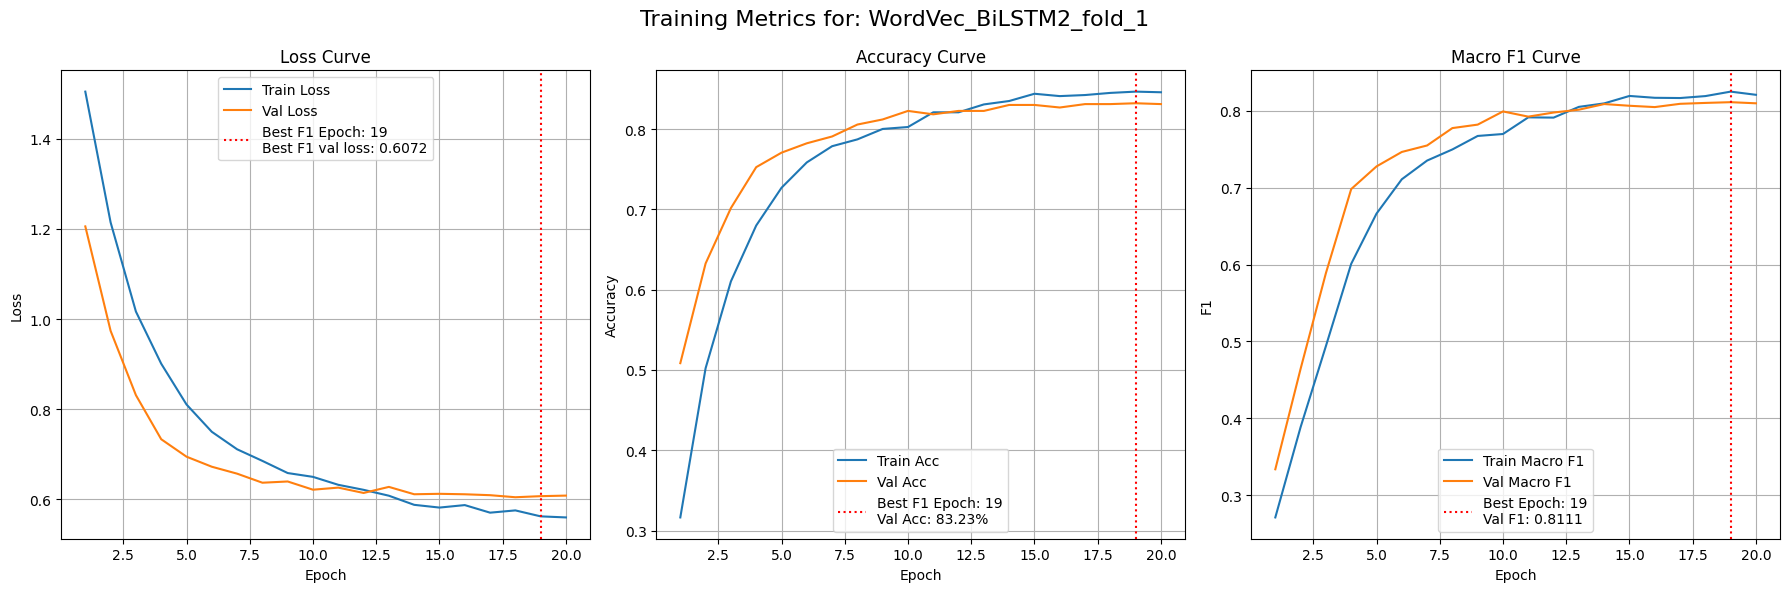

  Logging Fold 1 results under run_id: 5f15d47c1b184079913b1d4247c20ded
  Logged best model for Fold 1 to artifacts/model_weights//kaggle/working/models/WordVec_BiLSTM2_fold_1_state_dict.pt
Matthews correlation coefficient: 0.761939637180072
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.85      0.94      0.89       379
LIGHT_PROFANITY       0.76      0.72      0.74       188
 HIGH_PROFANITY       0.83      0.75      0.79       120
       VIOLENCE       0.85      0.80      0.82       255

       accuracy                           0.83       942
      macro avg       0.82      0.80      0.81       942
   weighted avg       0.83      0.83      0.83       942

PR curve will be saved as WordVec_BiLSTM2_fold_1_PR.png


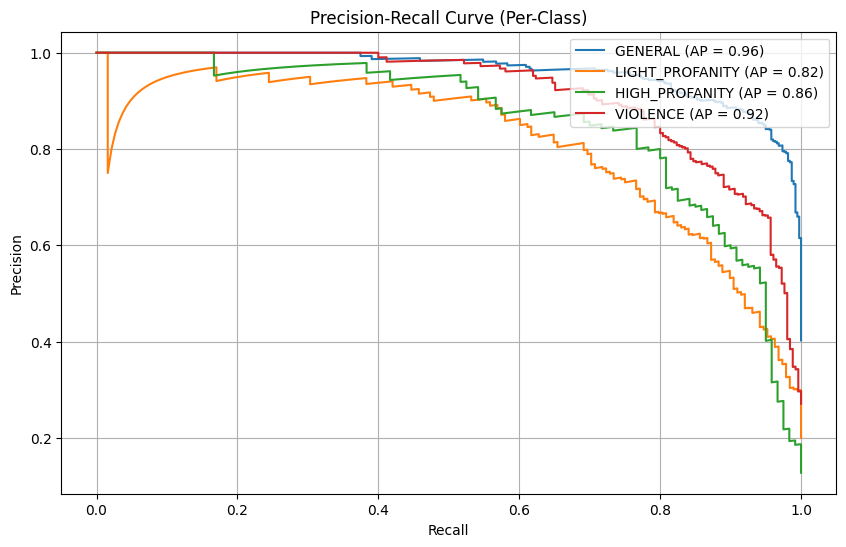

Confusion Matrix will be saved as WordVec_BiLSTM2_fold_1_cm.png


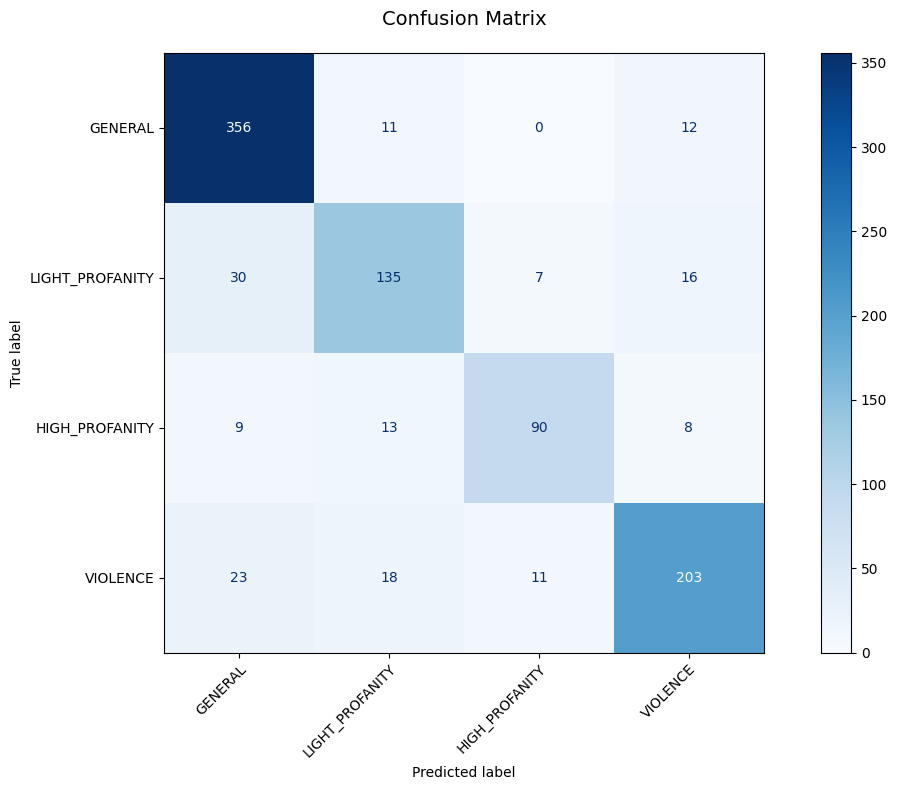

  Logged evaluation plots for Fold 1
🏃 View run Fold 1 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/5f15d47c1b184079913b1d4247c20ded
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2
Epoch 1/20 | Train Loss: 1.6649 | Val Loss: 1.1989 | Train F1: 0.2267 | Val F1: 0.3176
Epoch 2/20 | Train Loss: 1.2113 | Val Loss: 0.9330 | Train F1: 0.3833 | Val F1: 0.4798
Epoch 3/20 | Train Loss: 1.0038 | Val Loss: 0.8020 | Train F1: 0.5190 | Val F1: 0.6387
Epoch 4/20 | Train Loss: 0.8767 | Val Loss: 0.7453 | Train F1: 0.6164 | Val F1: 0.6813
Epoch 5/20 | Train Loss: 0.8022 | Val Loss: 0.6786 | Train F1: 0.6704 | Val F1: 0.7444
Epoch 6/20 | Train Loss: 0.7517 | Val Loss: 0.6548 | Train F1: 0.7097 | Val F1: 0.7651
Epoch 7/20 | Train Loss: 0.7064 | Val Loss: 0.6548 | Train F1: 0.7383 | Val F1: 0.7813
Epoch 8/20 | Train Loss: 0.6724 | Val Loss: 0.6206 | Train F1: 0.7580 | Val F1: 0.8002
Epoch 9/20 | Train Loss: 0.6533 | Val Loss: 0.621

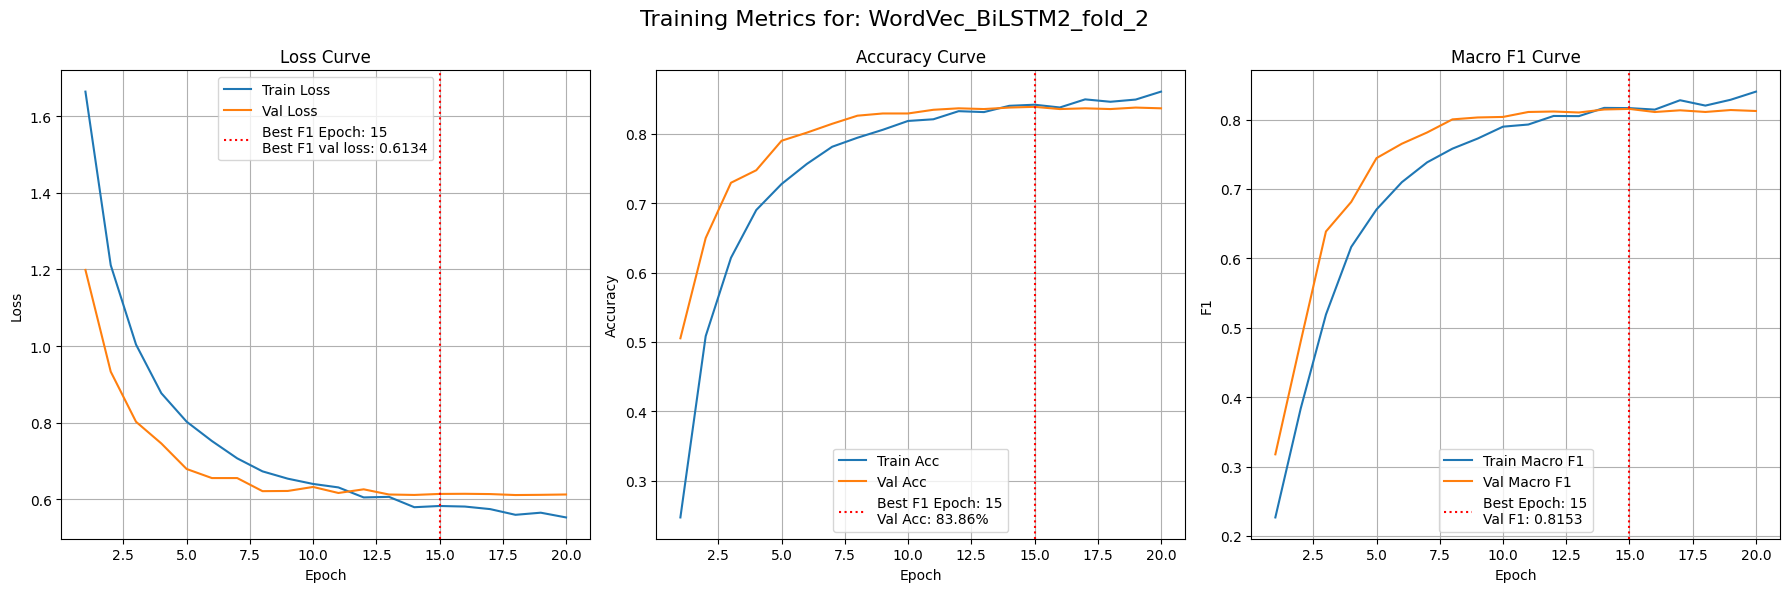

  Logging Fold 2 results under run_id: 4aaebcc9b5e14e71a5099ba57c9433ed
  Logged best model for Fold 2 to artifacts/model_weights//kaggle/working/models/WordVec_BiLSTM2_fold_2_state_dict.pt
Matthews correlation coefficient: 0.7714997145858465
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.85      0.95      0.90       379
LIGHT_PROFANITY       0.81      0.73      0.77       187
 HIGH_PROFANITY       0.78      0.75      0.77       121
       VIOLENCE       0.87      0.79      0.83       255

       accuracy                           0.84       942
      macro avg       0.83      0.81      0.82       942
   weighted avg       0.84      0.84      0.84       942

PR curve will be saved as WordVec_BiLSTM2_fold_2_PR.png


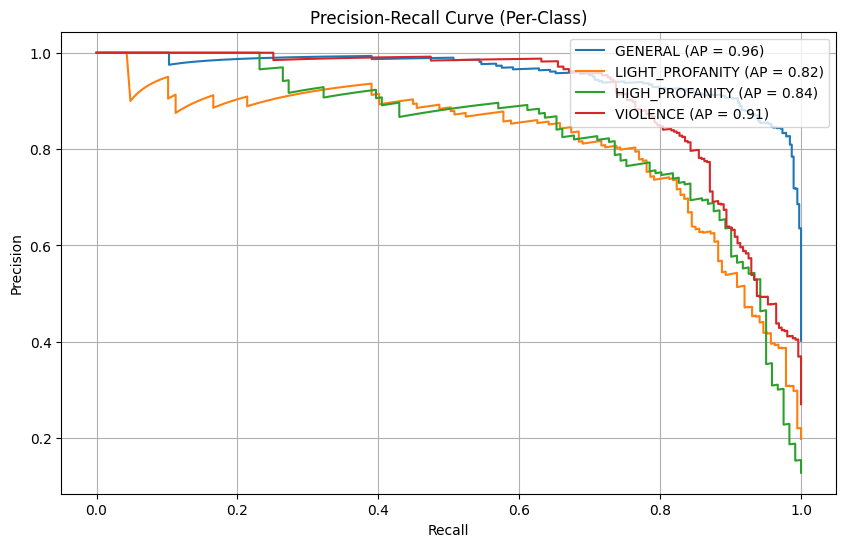

Confusion Matrix will be saved as WordVec_BiLSTM2_fold_2_cm.png


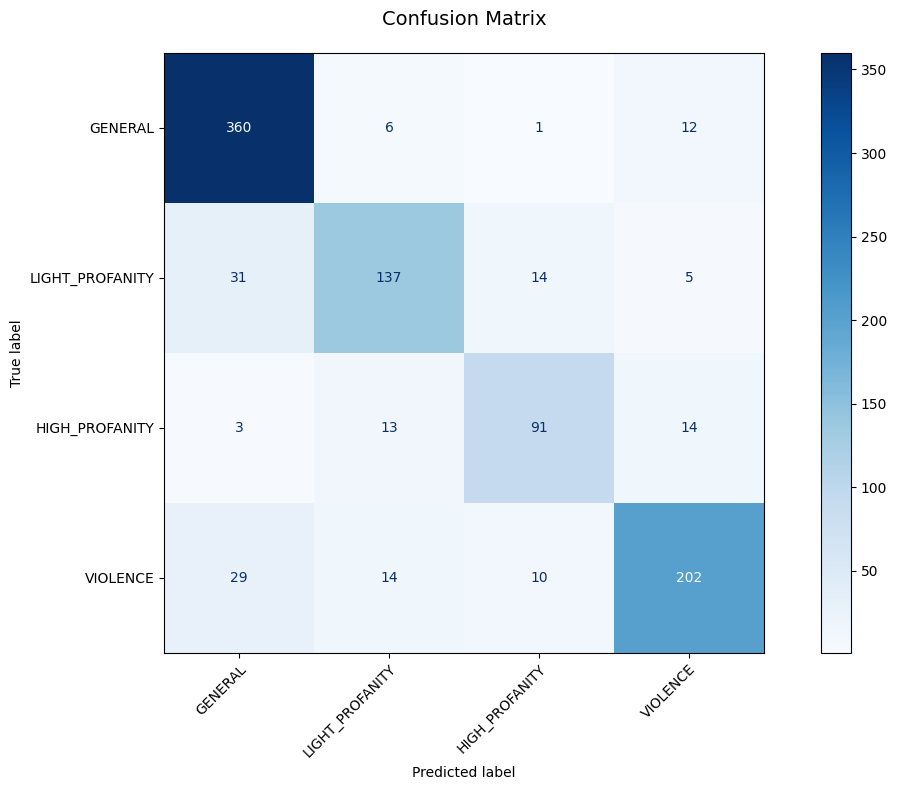

  Logged evaluation plots for Fold 2
🏃 View run Fold 2 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/4aaebcc9b5e14e71a5099ba57c9433ed
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2
Epoch 1/20 | Train Loss: 1.4943 | Val Loss: 1.2237 | Train F1: 0.2511 | Val F1: 0.3282
Epoch 2/20 | Train Loss: 1.2379 | Val Loss: 1.0026 | Train F1: 0.3651 | Val F1: 0.4179
Epoch 3/20 | Train Loss: 1.0429 | Val Loss: 0.8827 | Train F1: 0.4939 | Val F1: 0.5840
Epoch 4/20 | Train Loss: 0.9164 | Val Loss: 0.8090 | Train F1: 0.5806 | Val F1: 0.6479
Epoch 5/20 | Train Loss: 0.8210 | Val Loss: 0.7807 | Train F1: 0.6678 | Val F1: 0.6859
Epoch 6/20 | Train Loss: 0.7843 | Val Loss: 0.7491 | Train F1: 0.7014 | Val F1: 0.7165
Epoch 7/20 | Train Loss: 0.7297 | Val Loss: 0.7334 | Train F1: 0.7315 | Val F1: 0.7400
Epoch 8/20 | Train Loss: 0.6990 | Val Loss: 0.7081 | Train F1: 0.7538 | Val F1: 0.7455
Epoch 9/20 | Train Loss: 0.6710 | Val Loss: 0.697

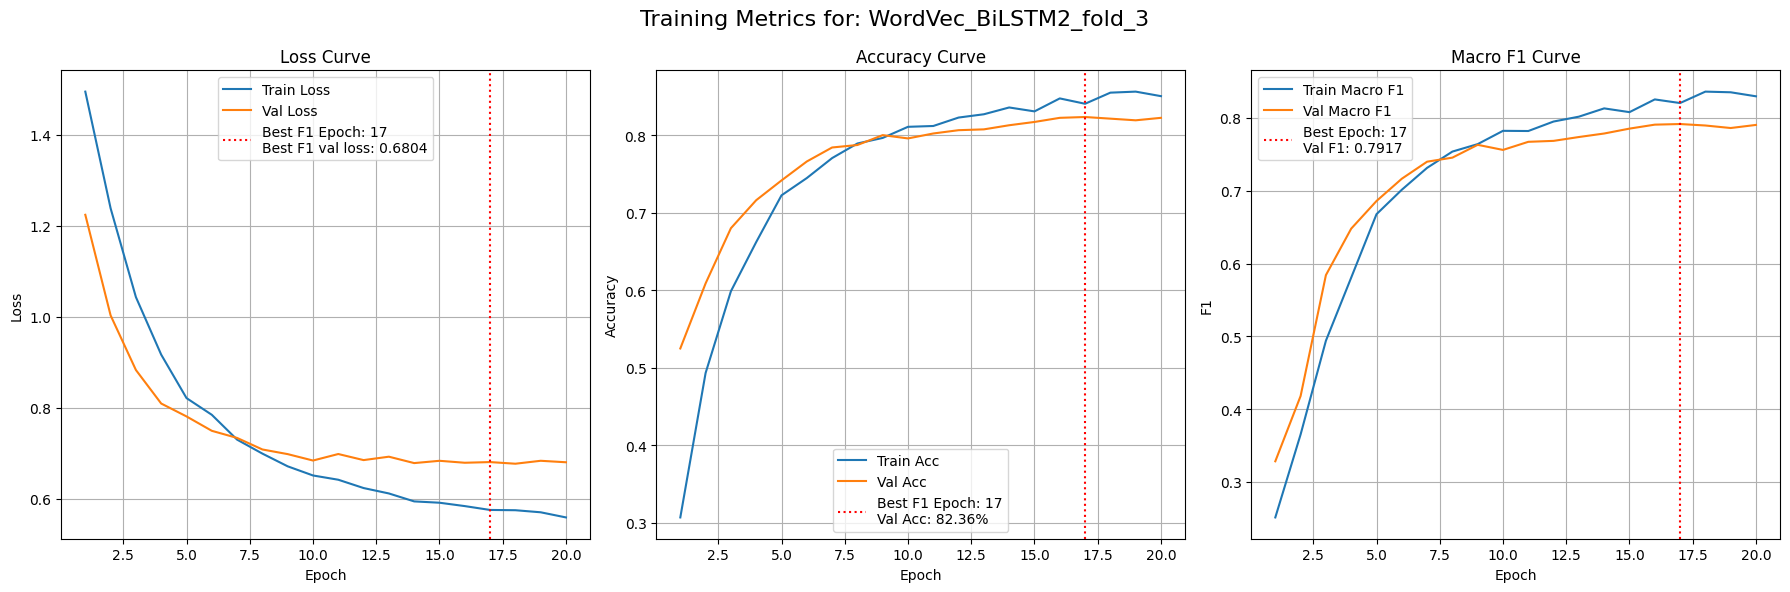

  Logging Fold 3 results under run_id: 2f0353159f48468dad5ecc09aeda124a
  Logged best model for Fold 3 to artifacts/model_weights//kaggle/working/models/WordVec_BiLSTM2_fold_3_state_dict.pt
Matthews correlation coefficient: 0.7502623588031451
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.85      0.97      0.91       379
LIGHT_PROFANITY       0.78      0.66      0.72       187
 HIGH_PROFANITY       0.74      0.74      0.74       120
       VIOLENCE       0.84      0.77      0.80       255

       accuracy                           0.82       941
      macro avg       0.80      0.78      0.79       941
   weighted avg       0.82      0.82      0.82       941

PR curve will be saved as WordVec_BiLSTM2_fold_3_PR.png


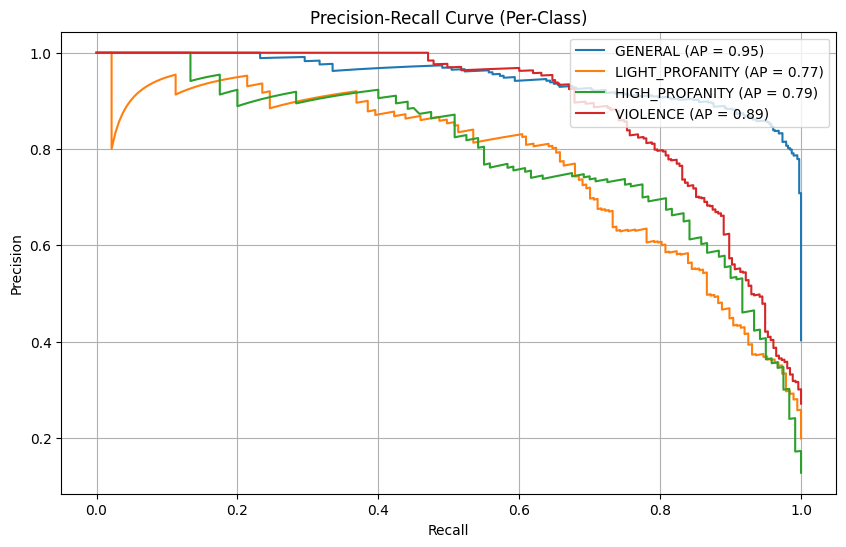

Confusion Matrix will be saved as WordVec_BiLSTM2_fold_3_cm.png


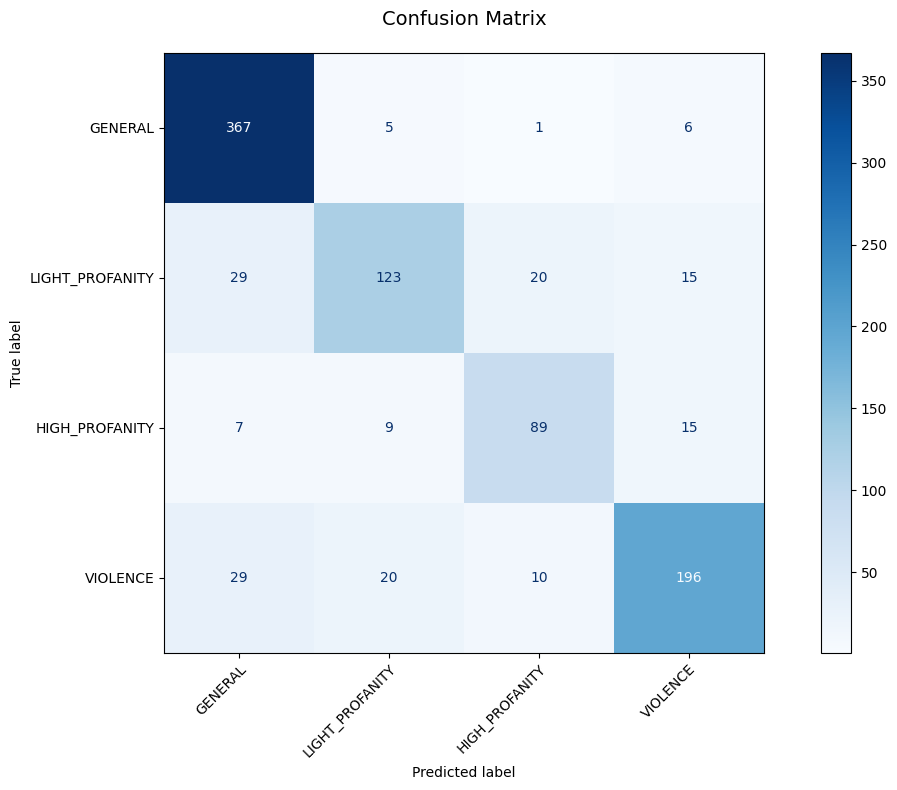

  Logged evaluation plots for Fold 3
🏃 View run Fold 3 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/2f0353159f48468dad5ecc09aeda124a
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2
Epoch 1/20 | Train Loss: 1.4707 | Val Loss: 1.1964 | Train F1: 0.2664 | Val F1: 0.3305
Epoch 2/20 | Train Loss: 1.2256 | Val Loss: 0.9705 | Train F1: 0.3723 | Val F1: 0.4502
Epoch 3/20 | Train Loss: 1.0230 | Val Loss: 0.8442 | Train F1: 0.5055 | Val F1: 0.5736
Epoch 4/20 | Train Loss: 0.9007 | Val Loss: 0.7783 | Train F1: 0.5936 | Val F1: 0.6505
Epoch 5/20 | Train Loss: 0.8089 | Val Loss: 0.7294 | Train F1: 0.6710 | Val F1: 0.6891
Epoch 6/20 | Train Loss: 0.7555 | Val Loss: 0.7157 | Train F1: 0.7049 | Val F1: 0.7267
Epoch 7/20 | Train Loss: 0.7216 | Val Loss: 0.6827 | Train F1: 0.7260 | Val F1: 0.7470
Epoch 8/20 | Train Loss: 0.6933 | Val Loss: 0.6698 | Train F1: 0.7509 | Val F1: 0.7538
Epoch 9/20 | Train Loss: 0.6634 | Val Loss: 0.661

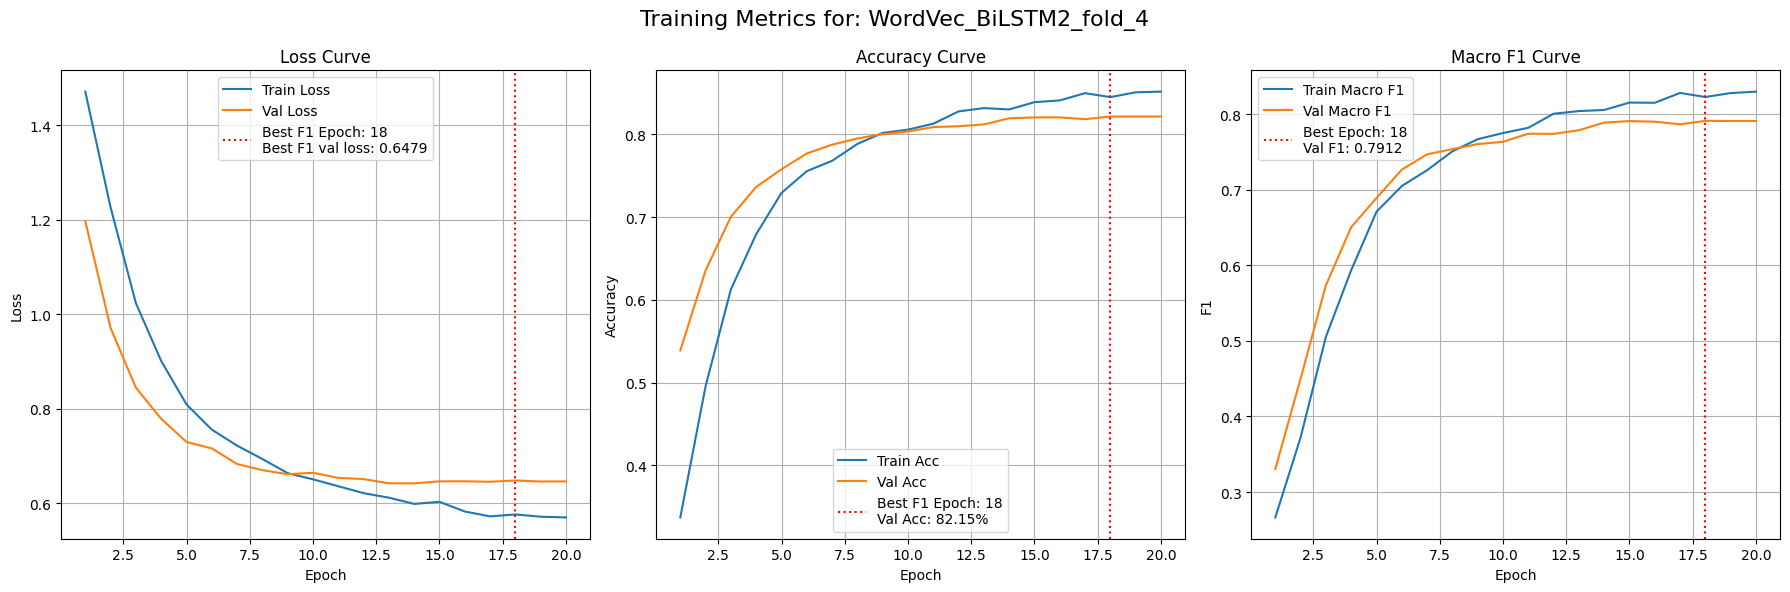

  Logging Fold 4 results under run_id: fa1bfa426bc9461a9ec76f688ccf7e78
  Logged best model for Fold 4 to artifacts/model_weights//kaggle/working/models/WordVec_BiLSTM2_fold_4_state_dict.pt
Matthews correlation coefficient: 0.7474214283010805
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.84      0.95      0.89       378
LIGHT_PROFANITY       0.82      0.66      0.73       188
 HIGH_PROFANITY       0.72      0.73      0.72       120
       VIOLENCE       0.85      0.80      0.82       255

       accuracy                           0.82       941
      macro avg       0.80      0.78      0.79       941
   weighted avg       0.82      0.82      0.82       941

PR curve will be saved as WordVec_BiLSTM2_fold_4_PR.png


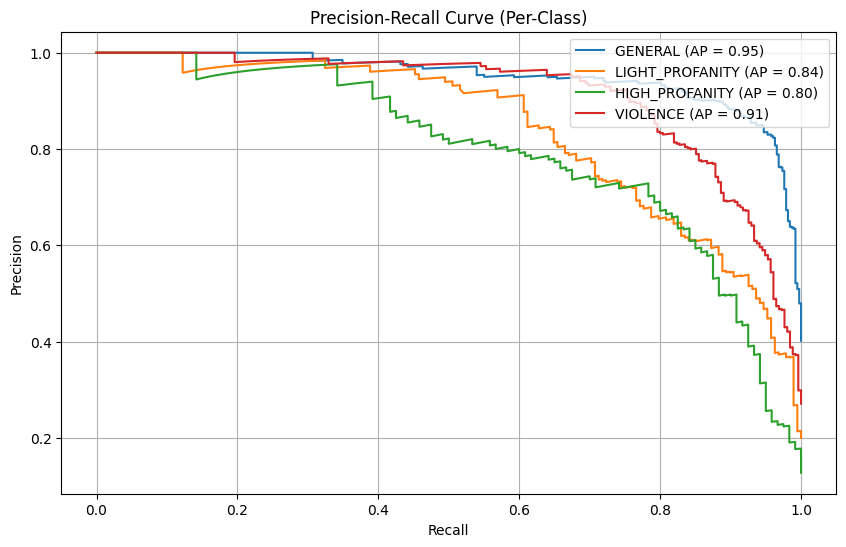

Confusion Matrix will be saved as WordVec_BiLSTM2_fold_4_cm.png


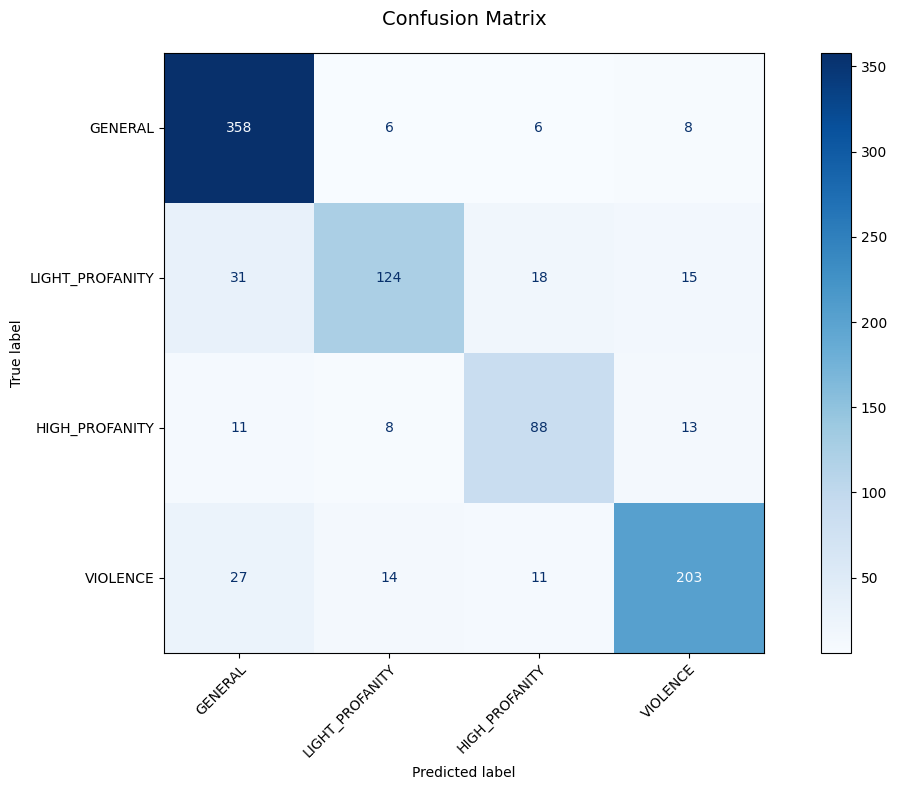

  Logged evaluation plots for Fold 4
🏃 View run Fold 4 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/fa1bfa426bc9461a9ec76f688ccf7e78
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2
Epoch 1/20 | Train Loss: 1.5579 | Val Loss: 1.2090 | Train F1: 0.2606 | Val F1: 0.3359
Epoch 2/20 | Train Loss: 1.2254 | Val Loss: 0.9817 | Train F1: 0.3860 | Val F1: 0.4563
Epoch 3/20 | Train Loss: 1.0178 | Val Loss: 0.8575 | Train F1: 0.5062 | Val F1: 0.5726
Epoch 4/20 | Train Loss: 0.8725 | Val Loss: 0.8041 | Train F1: 0.6147 | Val F1: 0.6437
Epoch 5/20 | Train Loss: 0.7957 | Val Loss: 0.7835 | Train F1: 0.6802 | Val F1: 0.6903
Epoch 6/20 | Train Loss: 0.7446 | Val Loss: 0.7603 | Train F1: 0.7128 | Val F1: 0.7156
Epoch 7/20 | Train Loss: 0.7141 | Val Loss: 0.7591 | Train F1: 0.7315 | Val F1: 0.7231
Epoch 8/20 | Train Loss: 0.6699 | Val Loss: 0.7564 | Train F1: 0.7605 | Val F1: 0.7233
Epoch 9/20 | Train Loss: 0.6580 | Val Loss: 0.746

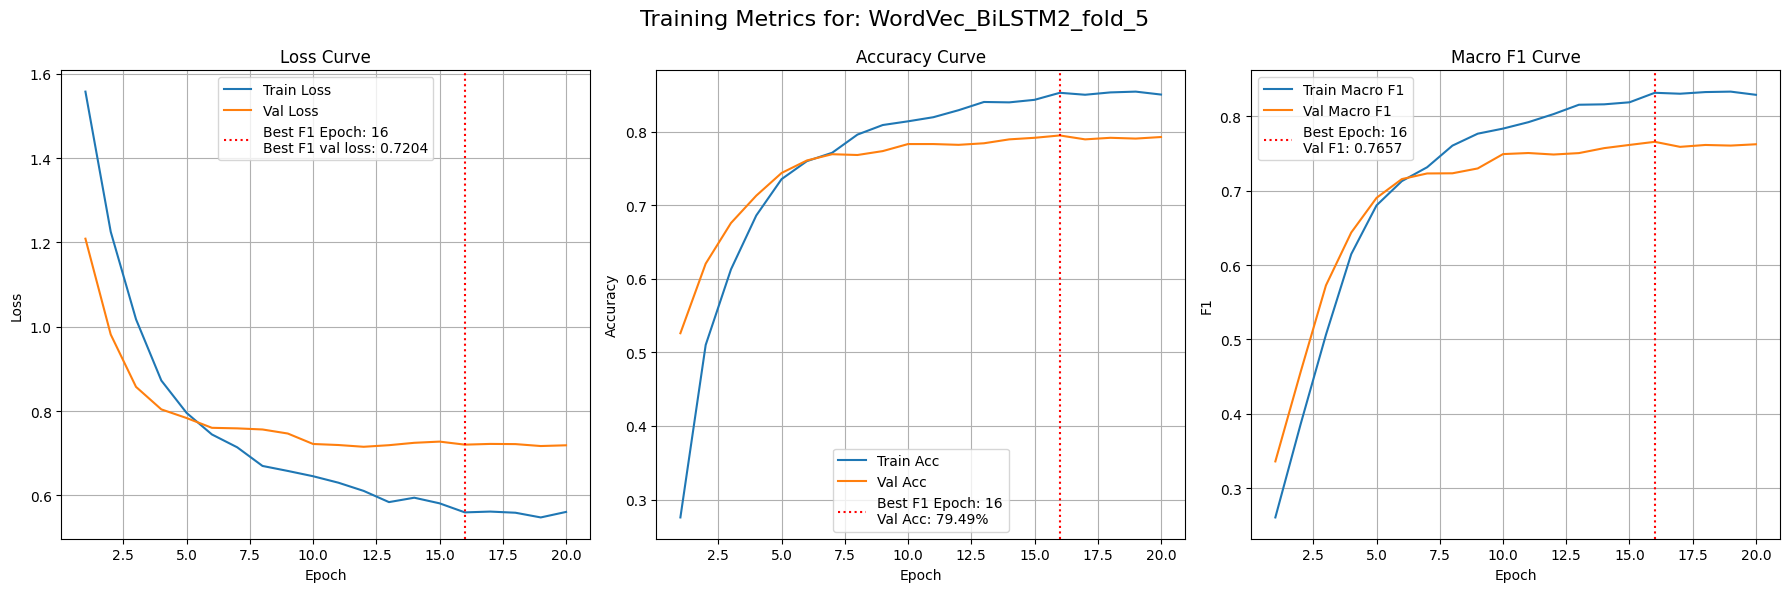

  Logging Fold 5 results under run_id: 69e2d559588e42b9a018caf90fb7008b
  Logged best model for Fold 5 to artifacts/model_weights//kaggle/working/models/WordVec_BiLSTM2_fold_5_state_dict.pt
Matthews correlation coefficient: 0.7089509203292422
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.83      0.94      0.88       378
LIGHT_PROFANITY       0.70      0.65      0.67       188
 HIGH_PROFANITY       0.77      0.71      0.74       120
       VIOLENCE       0.82      0.73      0.77       255

       accuracy                           0.79       941
      macro avg       0.78      0.76      0.77       941
   weighted avg       0.79      0.79      0.79       941

PR curve will be saved as WordVec_BiLSTM2_fold_5_PR.png


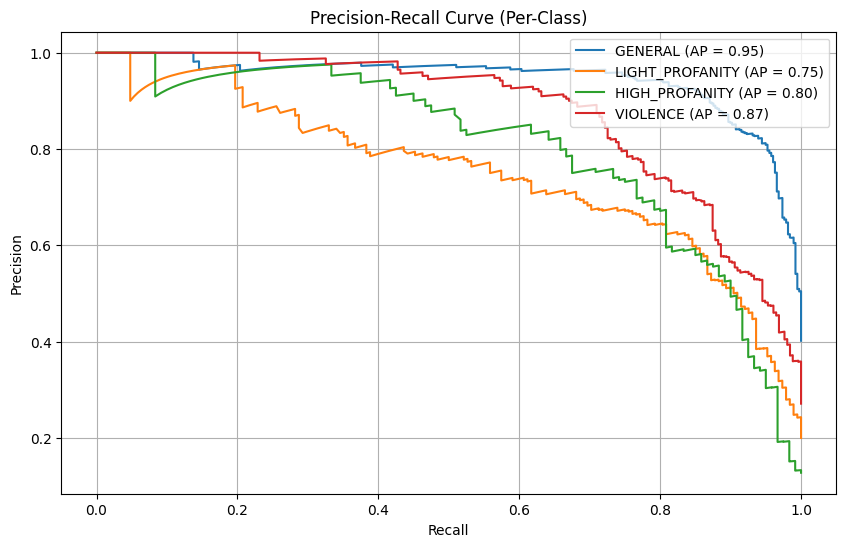

Confusion Matrix will be saved as WordVec_BiLSTM2_fold_5_cm.png


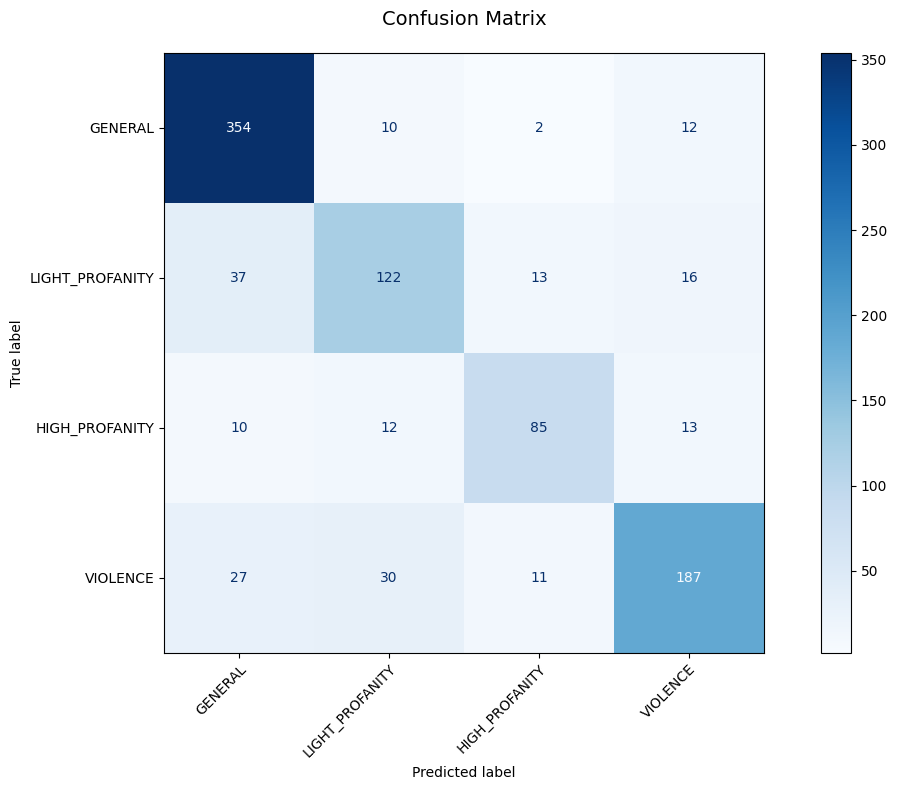

  Logged evaluation plots for Fold 5
🏃 View run Fold 5 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/69e2d559588e42b9a018caf90fb7008b
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2

Aggregating results for WordVec_BiLSTM2 across 5 folds...
Overall Results for WordVec_BiLSTM2:
  Avg Accuracy: 0.8222
  Avg Macro F1: 0.7950
  Avg Macro precision: 0.8079
  Avg Macro recall: 0.7865
  Avg Weighted F1: 0.8190
  Avg MCC: 0.7480

Performing Overall Out-of-Fold Evaluation for WordVec_BiLSTM2...
Overall Out-of-Fold Classification Report for WordVec_BiLSTM2:
                 precision    recall  f1-score   support

        GENERAL       0.84      0.95      0.89      1893
LIGHT_PROFANITY       0.77      0.68      0.73       938
 HIGH_PROFANITY       0.77      0.74      0.75       601
       VIOLENCE       0.85      0.78      0.81      1275

       accuracy                           0.82      4707
      macro avg       0.81   

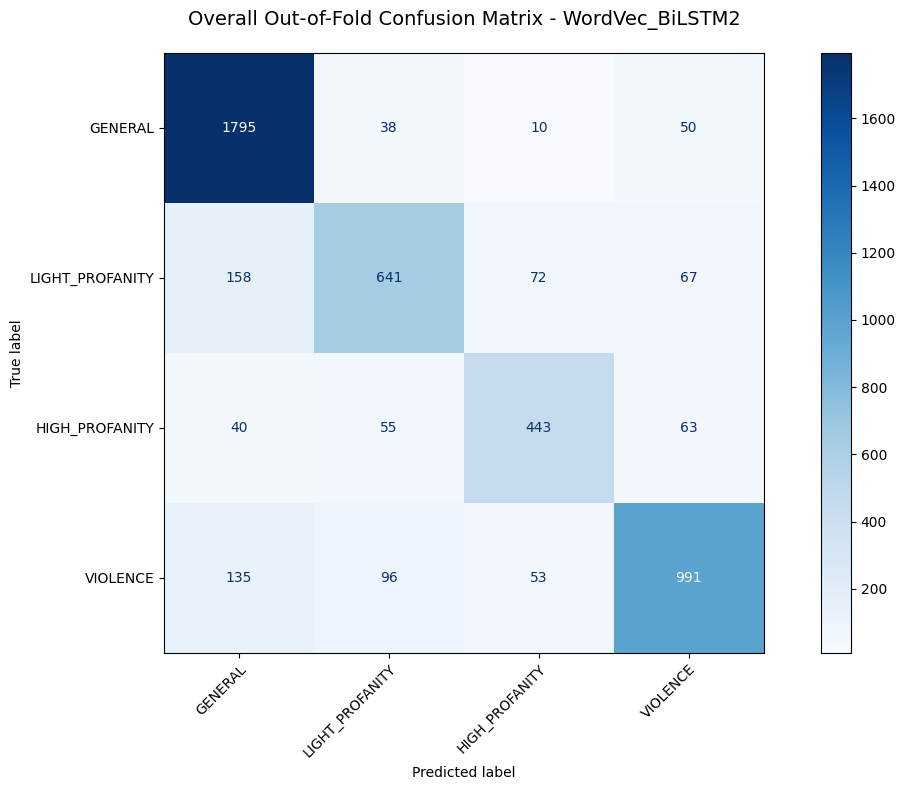

🏃 View run WordVec_BiLSTM2 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/be7a8189f27947c881a60e1082724ccb
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2


In [18]:
BiLSTM2_cv_outputs = run_cross_validation(architectures_to_test[0], dataset, all_labels, device, label_map, n_splits=5, num_classes=num_classes)

## BiLSTM cross validation


Starting Cross-Validation for: WordVec_BiLSTM
Epoch 1/20 | Train Loss: 1.3705 | Val Loss: 1.2203 | Train F1: 0.3071 | Val F1: 0.3482
Epoch 2/20 | Train Loss: 1.1615 | Val Loss: 1.0146 | Train F1: 0.3925 | Val F1: 0.4591
Epoch 3/20 | Train Loss: 0.9853 | Val Loss: 0.8654 | Train F1: 0.4982 | Val F1: 0.5658
Epoch 4/20 | Train Loss: 0.8516 | Val Loss: 0.7704 | Train F1: 0.6159 | Val F1: 0.6719
Epoch 5/20 | Train Loss: 0.7660 | Val Loss: 0.7333 | Train F1: 0.6844 | Val F1: 0.7206
Epoch 6/20 | Train Loss: 0.7112 | Val Loss: 0.6859 | Train F1: 0.7288 | Val F1: 0.7397
Epoch 7/20 | Train Loss: 0.6749 | Val Loss: 0.6513 | Train F1: 0.7531 | Val F1: 0.7703
Epoch 8/20 | Train Loss: 0.6459 | Val Loss: 0.6507 | Train F1: 0.7672 | Val F1: 0.7768
Epoch 9/20 | Train Loss: 0.6126 | Val Loss: 0.6309 | Train F1: 0.7936 | Val F1: 0.7868
Epoch 10/20 | Train Loss: 0.6024 | Val Loss: 0.6237 | Train F1: 0.8024 | Val F1: 0.7914
Epoch 11/20 | Train Loss: 0.5854 | Val Loss: 0.6201 | Train F1: 0.8078 | Val F1: 0

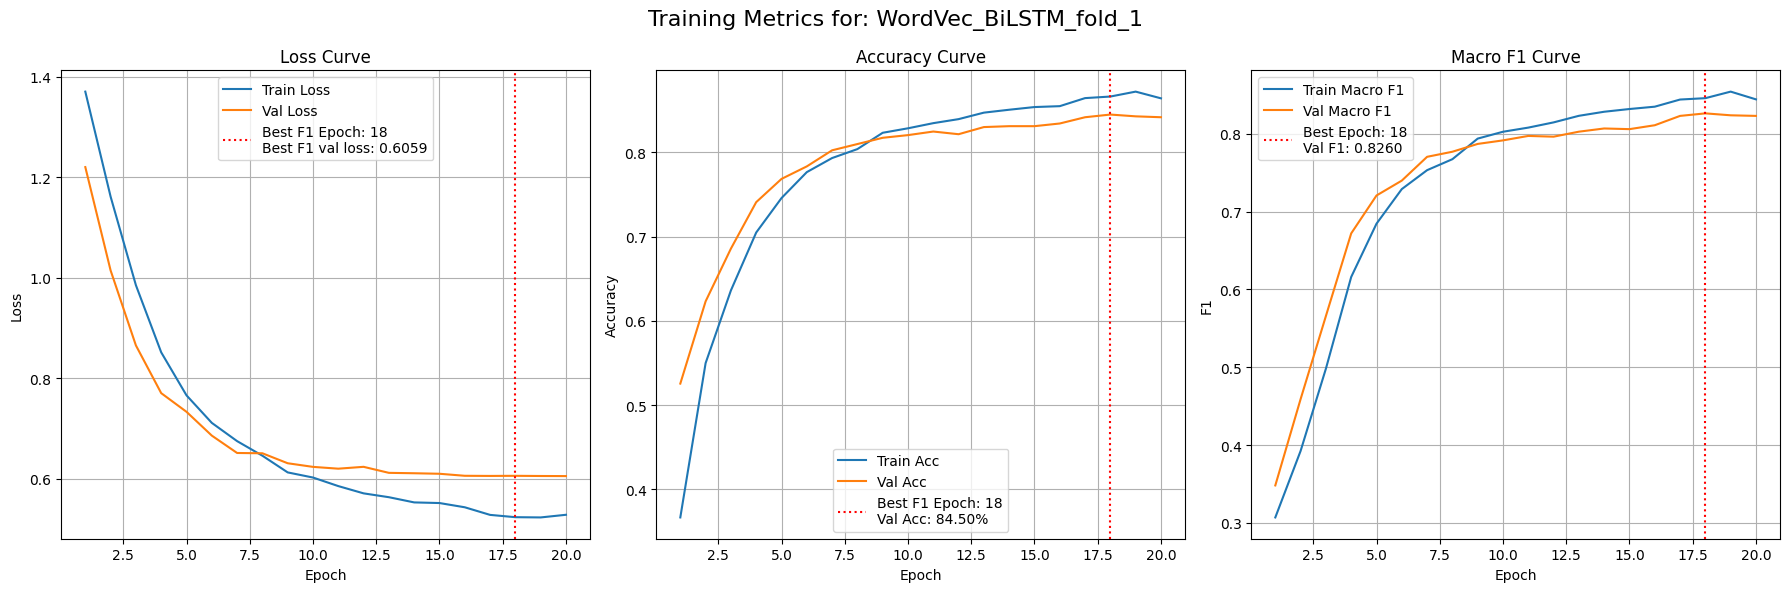

  Logging Fold 1 results under run_id: f32c93de866641c78cd839e88cbf87f8
  Logged best model for Fold 1 to artifacts/model_weights//kaggle/working/models/WordVec_BiLSTM_fold_1_state_dict.pt
Matthews correlation coefficient: 0.7803584203690023
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.88      0.93      0.90       379
LIGHT_PROFANITY       0.79      0.77      0.78       188
 HIGH_PROFANITY       0.82      0.78      0.80       120
       VIOLENCE       0.84      0.81      0.83       255

       accuracy                           0.85       942
      macro avg       0.83      0.82      0.83       942
   weighted avg       0.84      0.85      0.84       942

PR curve will be saved as WordVec_BiLSTM_fold_1_PR.png


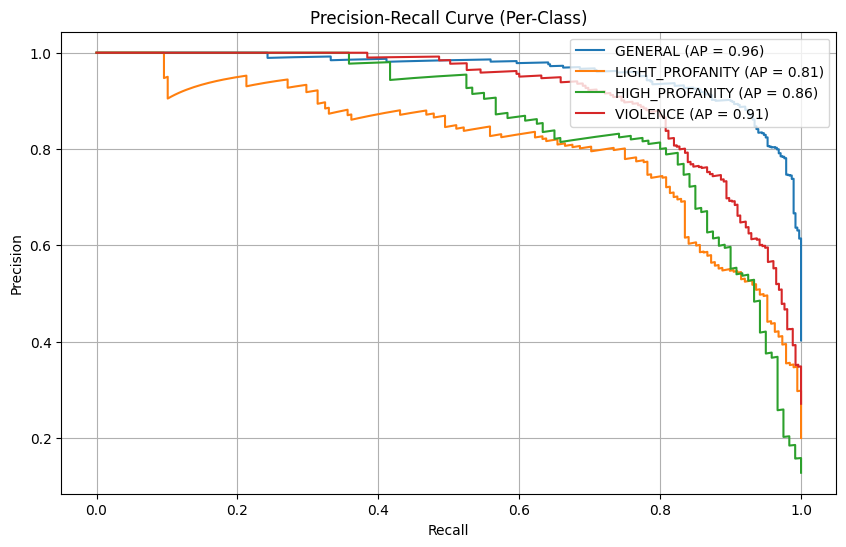

Confusion Matrix will be saved as WordVec_BiLSTM_fold_1_cm.png


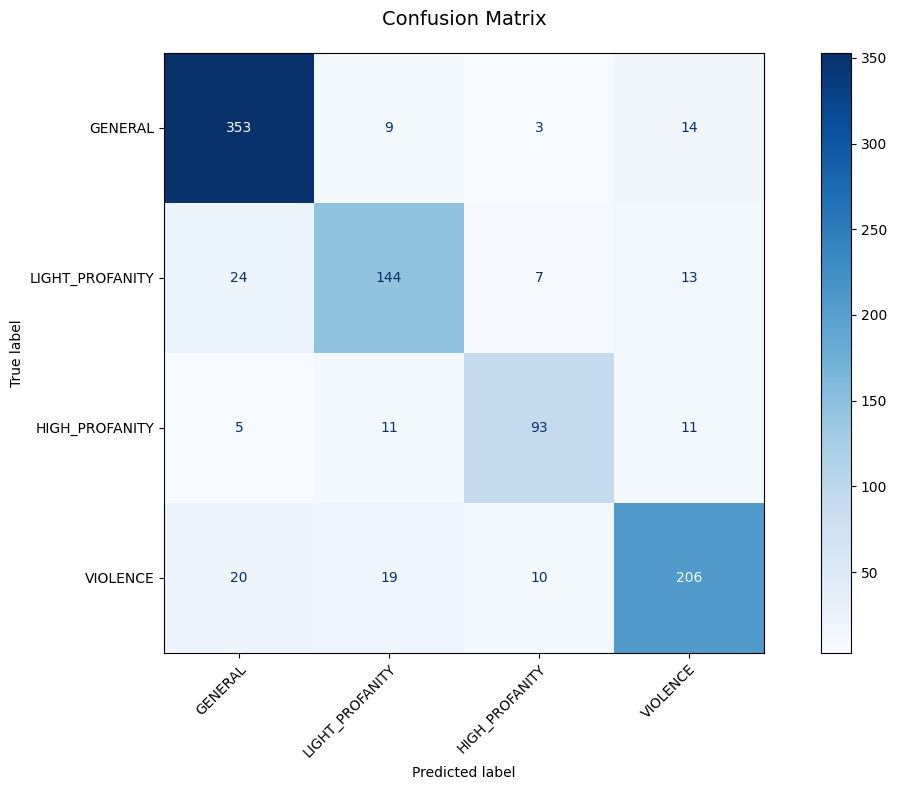

  Logged evaluation plots for Fold 1
🏃 View run Fold 1 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/f32c93de866641c78cd839e88cbf87f8
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2
Epoch 1/20 | Train Loss: 1.4391 | Val Loss: 1.3150 | Train F1: 0.2085 | Val F1: 0.2475
Epoch 2/20 | Train Loss: 1.2445 | Val Loss: 1.0776 | Train F1: 0.3289 | Val F1: 0.4139
Epoch 3/20 | Train Loss: 1.0380 | Val Loss: 0.8937 | Train F1: 0.4635 | Val F1: 0.5185
Epoch 4/20 | Train Loss: 0.8787 | Val Loss: 0.7725 | Train F1: 0.5793 | Val F1: 0.6686
Epoch 5/20 | Train Loss: 0.7808 | Val Loss: 0.7083 | Train F1: 0.6718 | Val F1: 0.7311
Epoch 6/20 | Train Loss: 0.7212 | Val Loss: 0.6734 | Train F1: 0.7233 | Val F1: 0.7608
Epoch 7/20 | Train Loss: 0.6798 | Val Loss: 0.6554 | Train F1: 0.7502 | Val F1: 0.7720
Epoch 8/20 | Train Loss: 0.6472 | Val Loss: 0.6416 | Train F1: 0.7641 | Val F1: 0.7910
Epoch 9/20 | Train Loss: 0.6337 | Val Loss: 0.639

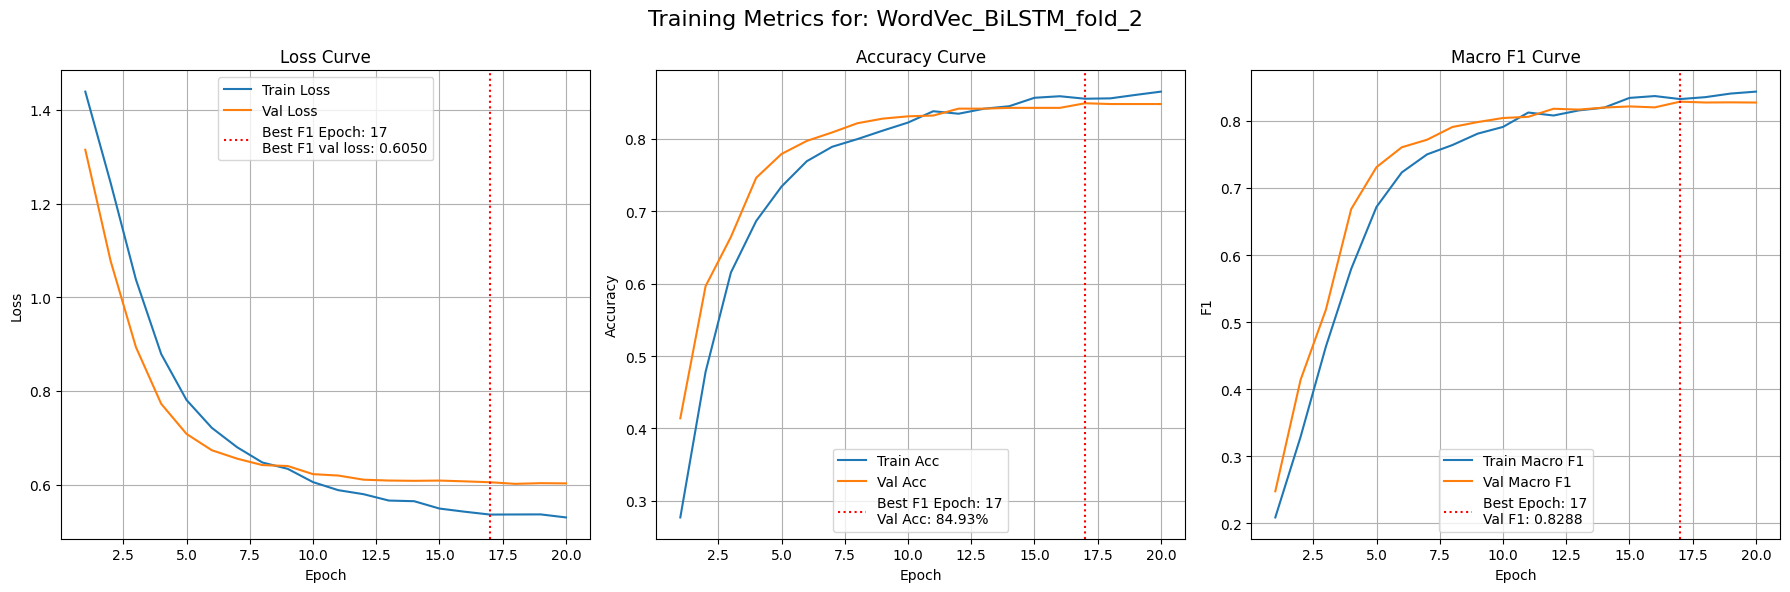

  Logging Fold 2 results under run_id: d7e3f16f4d434f1b8eeada9c955bc75b
  Logged best model for Fold 2 to artifacts/model_weights//kaggle/working/models/WordVec_BiLSTM_fold_2_state_dict.pt
Matthews correlation coefficient: 0.7870511378771011
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.86      0.96      0.91       379
LIGHT_PROFANITY       0.84      0.72      0.77       187
 HIGH_PROFANITY       0.79      0.82      0.80       121
       VIOLENCE       0.86      0.80      0.83       255

       accuracy                           0.85       942
      macro avg       0.84      0.82      0.83       942
   weighted avg       0.85      0.85      0.85       942

PR curve will be saved as WordVec_BiLSTM_fold_2_PR.png


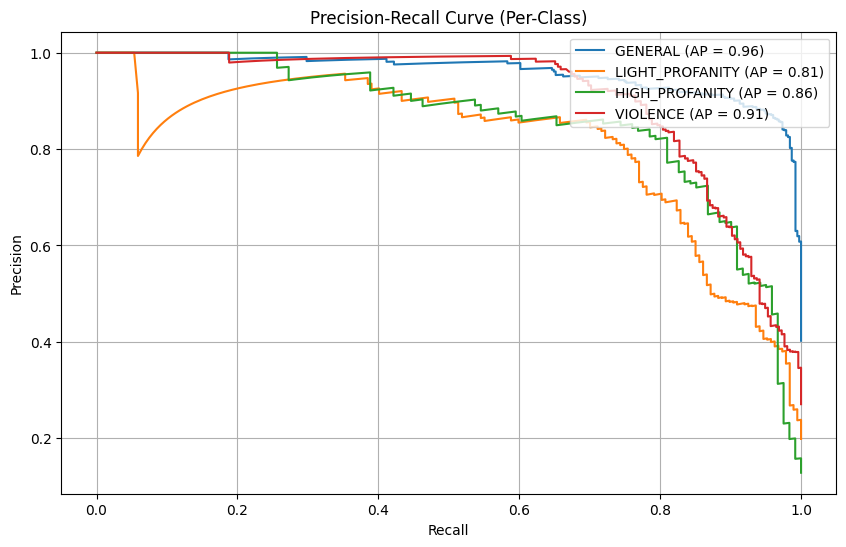

Confusion Matrix will be saved as WordVec_BiLSTM_fold_2_cm.png


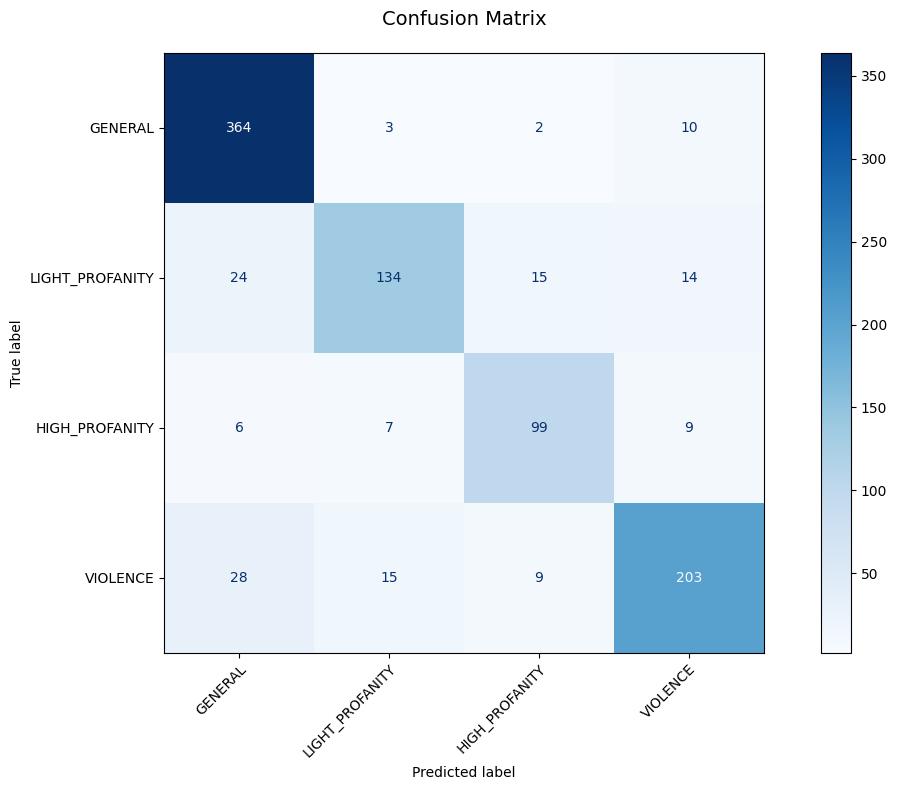

  Logged evaluation plots for Fold 2
🏃 View run Fold 2 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/d7e3f16f4d434f1b8eeada9c955bc75b
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2
Epoch 1/20 | Train Loss: 1.4939 | Val Loss: 1.2615 | Train F1: 0.2471 | Val F1: 0.3408
Epoch 2/20 | Train Loss: 1.1789 | Val Loss: 1.0454 | Train F1: 0.3883 | Val F1: 0.4213
Epoch 3/20 | Train Loss: 0.9879 | Val Loss: 0.8832 | Train F1: 0.4979 | Val F1: 0.5399
Epoch 4/20 | Train Loss: 0.8619 | Val Loss: 0.8045 | Train F1: 0.6085 | Val F1: 0.6230
Epoch 5/20 | Train Loss: 0.7796 | Val Loss: 0.7529 | Train F1: 0.6771 | Val F1: 0.6911
Epoch 6/20 | Train Loss: 0.7240 | Val Loss: 0.7086 | Train F1: 0.7161 | Val F1: 0.7262
Epoch 7/20 | Train Loss: 0.6809 | Val Loss: 0.6864 | Train F1: 0.7534 | Val F1: 0.7472
Epoch 8/20 | Train Loss: 0.6429 | Val Loss: 0.6738 | Train F1: 0.7820 | Val F1: 0.7447
Epoch 9/20 | Train Loss: 0.6259 | Val Loss: 0.659

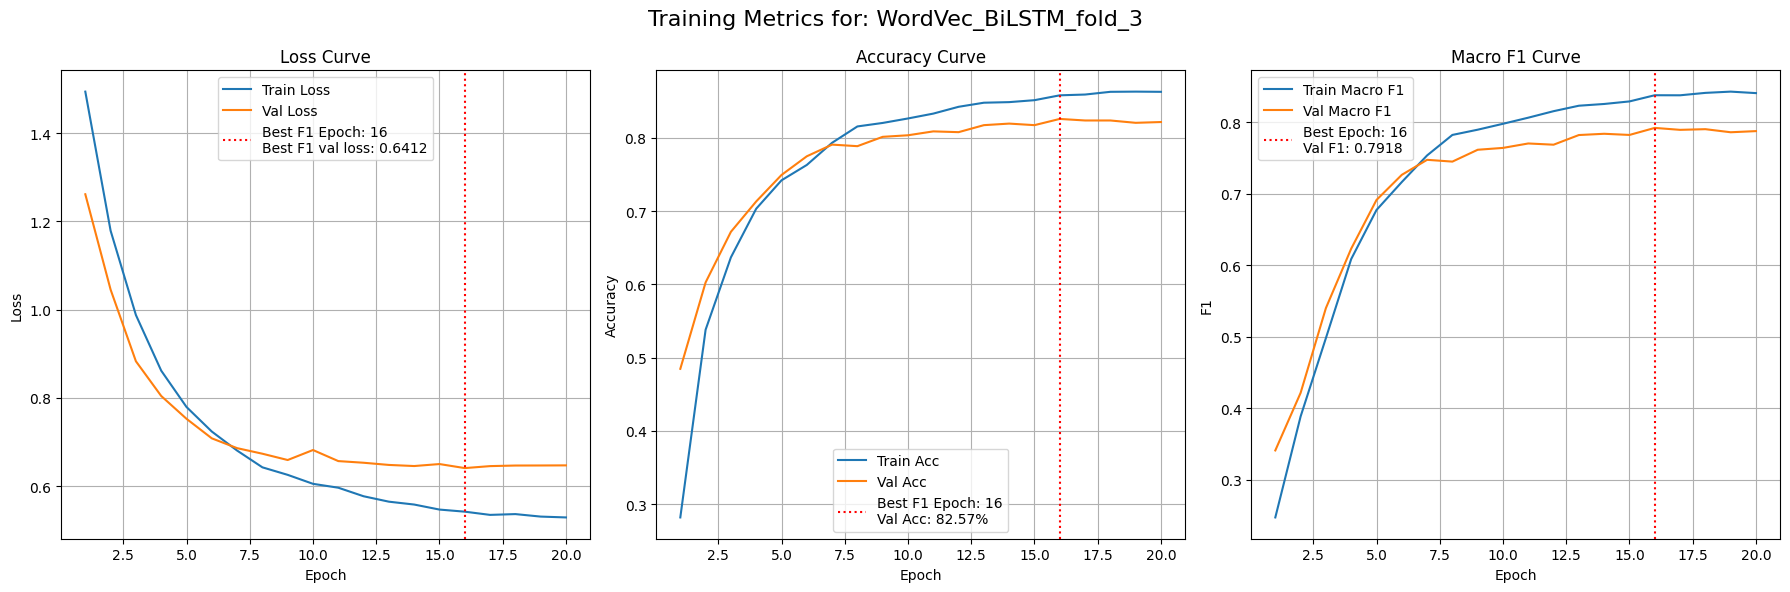

  Logging Fold 3 results under run_id: 6348263de02b4f5baf883b231d985145
  Logged best model for Fold 3 to artifacts/model_weights//kaggle/working/models/WordVec_BiLSTM_fold_3_state_dict.pt
Matthews correlation coefficient: 0.7532550004678846
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.86      0.97      0.91       379
LIGHT_PROFANITY       0.78      0.70      0.73       187
 HIGH_PROFANITY       0.72      0.72      0.72       120
       VIOLENCE       0.85      0.76      0.81       255

       accuracy                           0.83       941
      macro avg       0.80      0.79      0.79       941
   weighted avg       0.82      0.83      0.82       941

PR curve will be saved as WordVec_BiLSTM_fold_3_PR.png


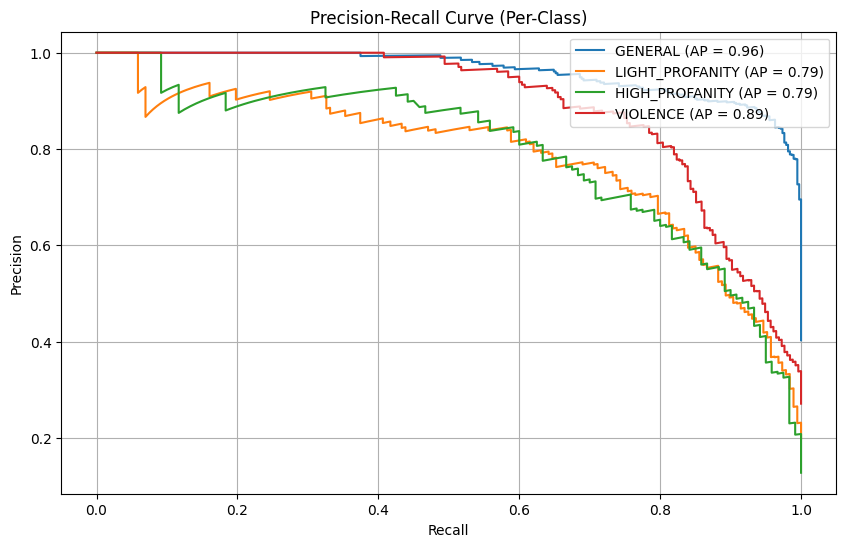

Confusion Matrix will be saved as WordVec_BiLSTM_fold_3_cm.png


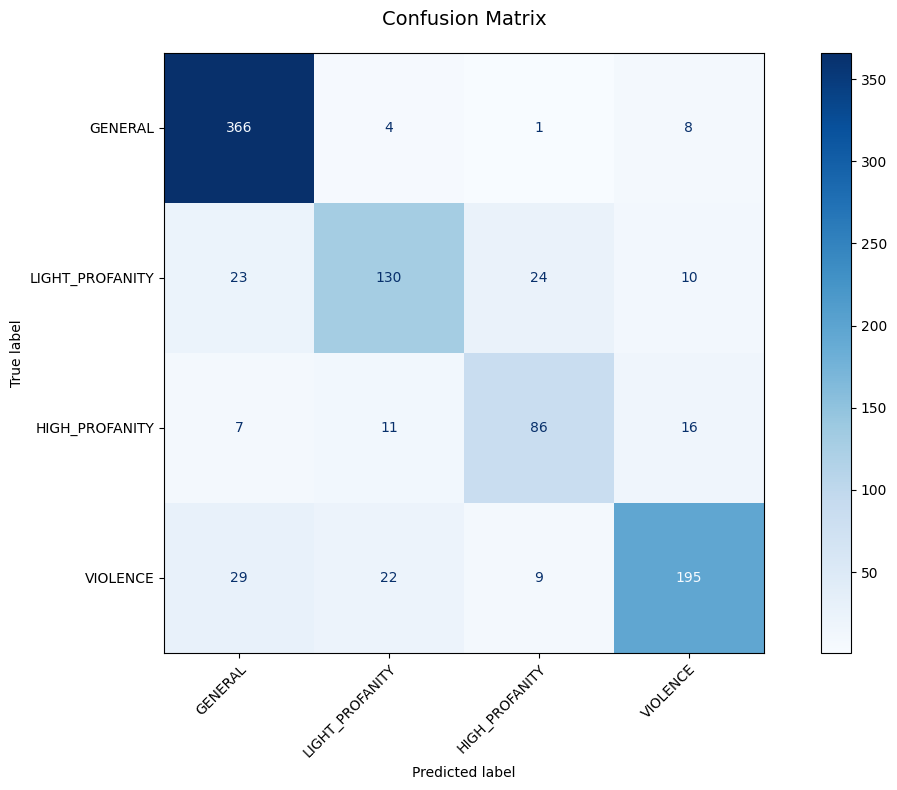

  Logged evaluation plots for Fold 3
🏃 View run Fold 3 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/6348263de02b4f5baf883b231d985145
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2
Epoch 1/20 | Train Loss: 1.4240 | Val Loss: 1.2763 | Train F1: 0.2331 | Val F1: 0.2915
Epoch 2/20 | Train Loss: 1.2114 | Val Loss: 1.0596 | Train F1: 0.3482 | Val F1: 0.4017
Epoch 3/20 | Train Loss: 1.0223 | Val Loss: 0.8924 | Train F1: 0.4588 | Val F1: 0.5303
Epoch 4/20 | Train Loss: 0.8958 | Val Loss: 0.7972 | Train F1: 0.5799 | Val F1: 0.6495
Epoch 5/20 | Train Loss: 0.7963 | Val Loss: 0.7394 | Train F1: 0.6728 | Val F1: 0.6940
Epoch 6/20 | Train Loss: 0.7378 | Val Loss: 0.7039 | Train F1: 0.7133 | Val F1: 0.7340
Epoch 7/20 | Train Loss: 0.6935 | Val Loss: 0.6763 | Train F1: 0.7446 | Val F1: 0.7448
Epoch 8/20 | Train Loss: 0.6589 | Val Loss: 0.6707 | Train F1: 0.7674 | Val F1: 0.7511
Epoch 9/20 | Train Loss: 0.6370 | Val Loss: 0.658

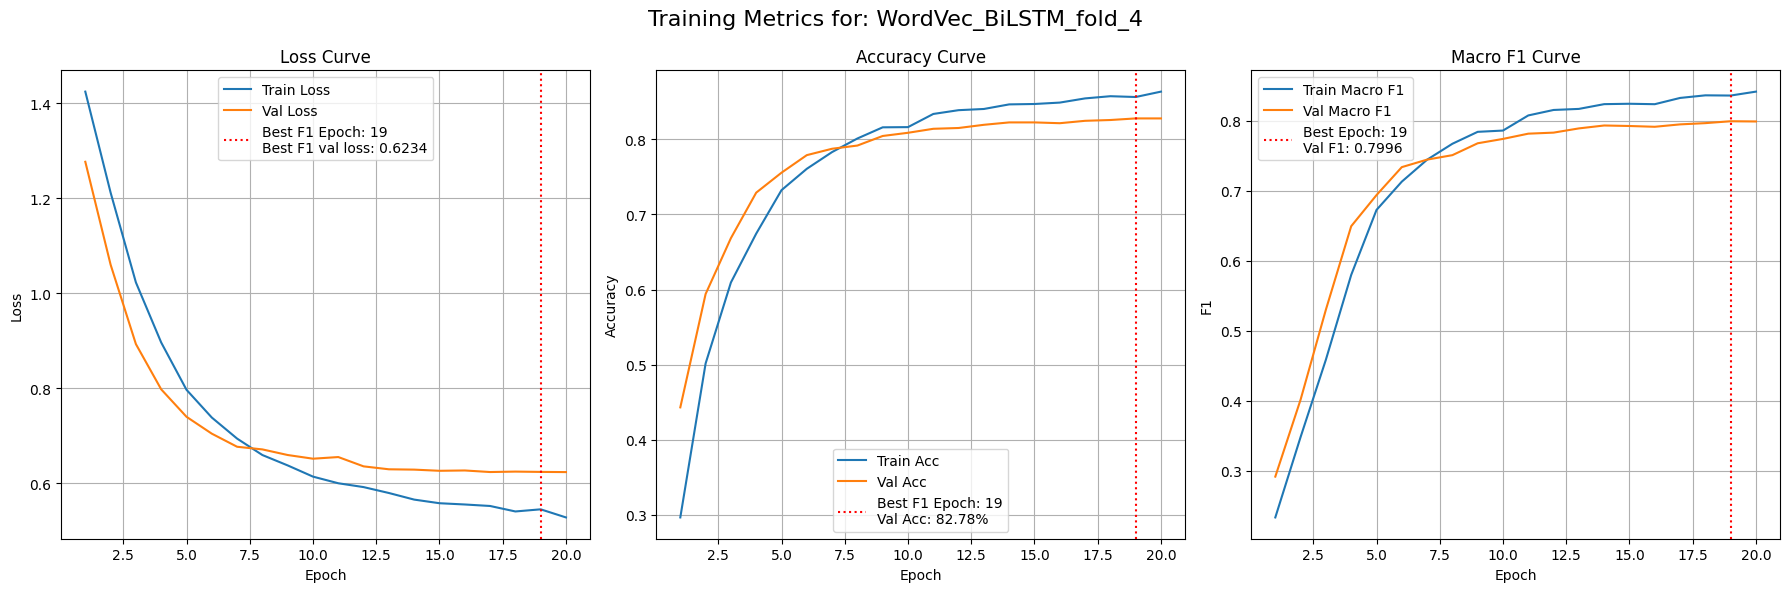

  Logging Fold 4 results under run_id: 0286e011fd7140c98d8e14ddd956fd32
  Logged best model for Fold 4 to artifacts/model_weights//kaggle/working/models/WordVec_BiLSTM_fold_4_state_dict.pt
Matthews correlation coefficient: 0.7561109335202395
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.85      0.93      0.89       378
LIGHT_PROFANITY       0.81      0.70      0.75       188
 HIGH_PROFANITY       0.72      0.72      0.73       120
       VIOLENCE       0.85      0.82      0.83       255

       accuracy                           0.83       941
      macro avg       0.81      0.79      0.80       941
   weighted avg       0.83      0.83      0.83       941

PR curve will be saved as WordVec_BiLSTM_fold_4_PR.png


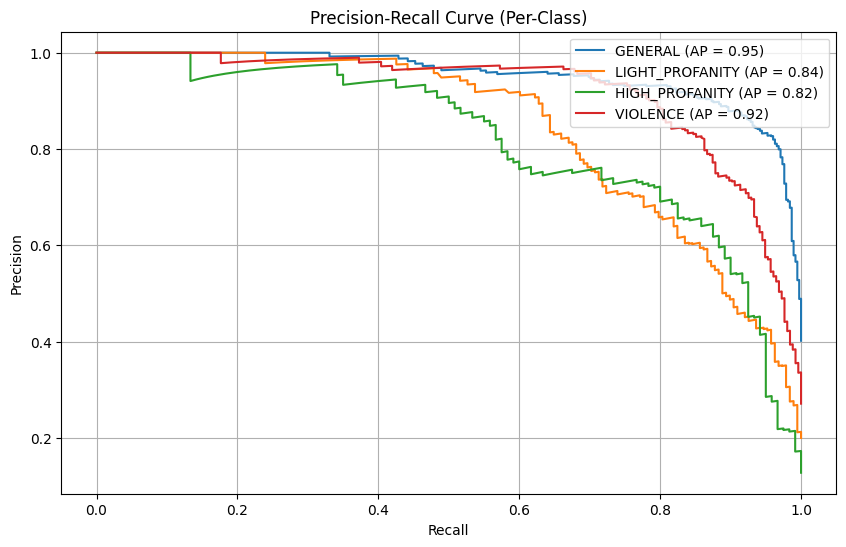

Confusion Matrix will be saved as WordVec_BiLSTM_fold_4_cm.png


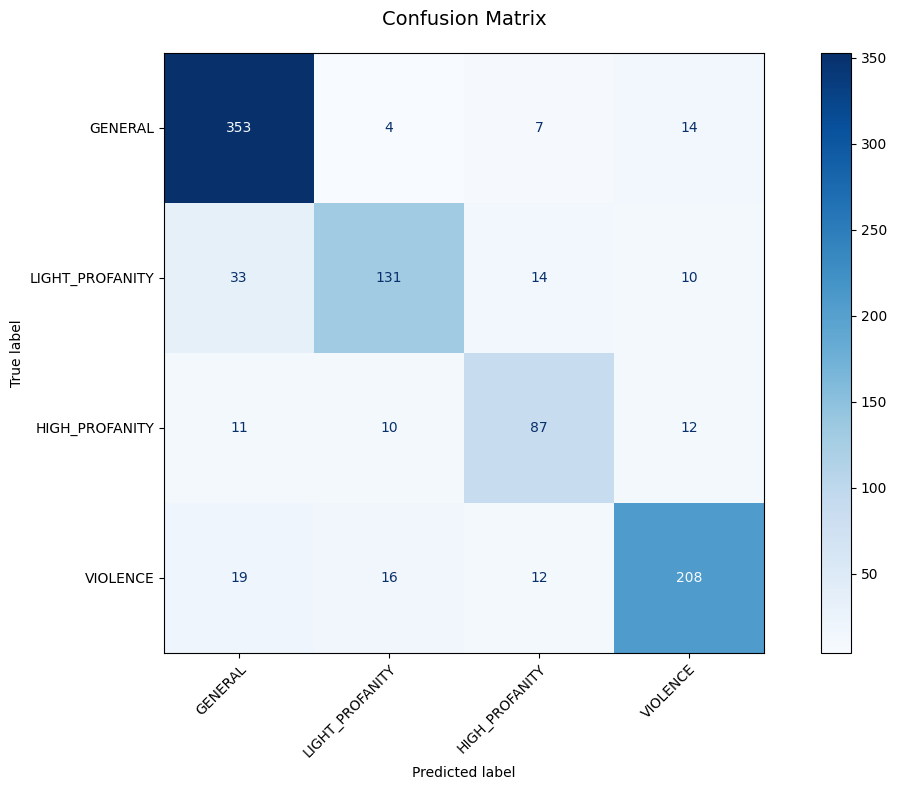

  Logged evaluation plots for Fold 4
🏃 View run Fold 4 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/0286e011fd7140c98d8e14ddd956fd32
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2
Epoch 1/20 | Train Loss: 1.4459 | Val Loss: 1.2857 | Train F1: 0.2389 | Val F1: 0.2410
Epoch 2/20 | Train Loss: 1.1905 | Val Loss: 1.0246 | Train F1: 0.3697 | Val F1: 0.4579
Epoch 3/20 | Train Loss: 0.9771 | Val Loss: 0.8667 | Train F1: 0.5228 | Val F1: 0.5340
Epoch 4/20 | Train Loss: 0.8402 | Val Loss: 0.7914 | Train F1: 0.6286 | Val F1: 0.6759
Epoch 5/20 | Train Loss: 0.7501 | Val Loss: 0.7560 | Train F1: 0.7058 | Val F1: 0.7168
Epoch 6/20 | Train Loss: 0.6838 | Val Loss: 0.7364 | Train F1: 0.7506 | Val F1: 0.7276
Epoch 7/20 | Train Loss: 0.6519 | Val Loss: 0.7259 | Train F1: 0.7696 | Val F1: 0.7421
Epoch 8/20 | Train Loss: 0.6228 | Val Loss: 0.7299 | Train F1: 0.7926 | Val F1: 0.7457
Epoch 9/20 | Train Loss: 0.5972 | Val Loss: 0.716

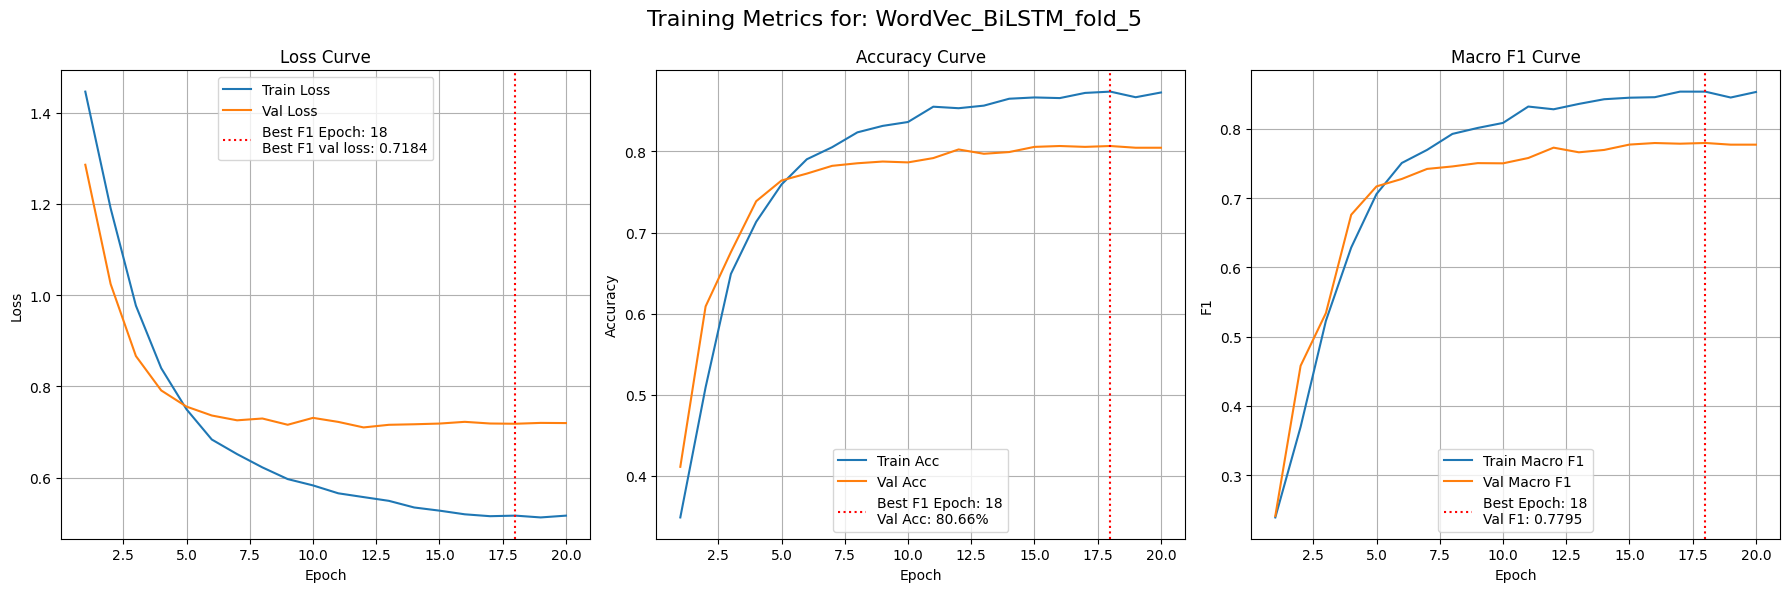

  Logging Fold 5 results under run_id: e990d626d08d4c1a886751d6336262f7
  Logged best model for Fold 5 to artifacts/model_weights//kaggle/working/models/WordVec_BiLSTM_fold_5_state_dict.pt
Matthews correlation coefficient: 0.7255419440310604
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.87      0.92      0.89       378
LIGHT_PROFANITY       0.74      0.71      0.72       188
 HIGH_PROFANITY       0.77      0.70      0.73       120
       VIOLENCE       0.78      0.76      0.77       255

       accuracy                           0.81       941
      macro avg       0.79      0.77      0.78       941
   weighted avg       0.80      0.81      0.80       941

PR curve will be saved as WordVec_BiLSTM_fold_5_PR.png


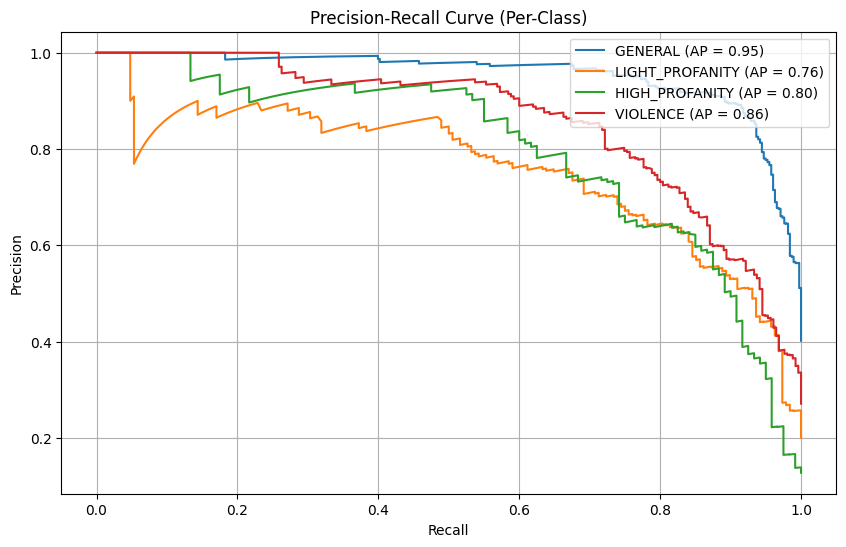

Confusion Matrix will be saved as WordVec_BiLSTM_fold_5_cm.png


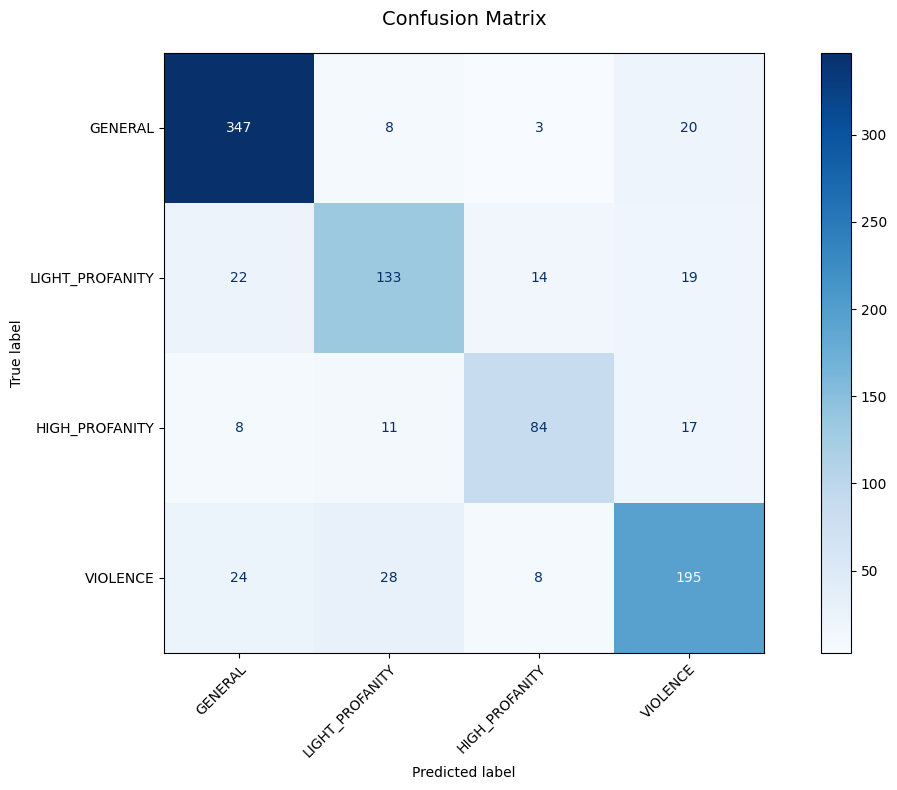

  Logged evaluation plots for Fold 5
🏃 View run Fold 5 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/e990d626d08d4c1a886751d6336262f7
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2

Aggregating results for WordVec_BiLSTM across 5 folds...
Overall Results for WordVec_BiLSTM:
  Avg Accuracy: 0.8309
  Avg Macro F1: 0.8052
  Avg Macro precision: 0.8145
  Avg Macro recall: 0.7988
  Avg Weighted F1: 0.8286
  Avg MCC: 0.7605

Performing Overall Out-of-Fold Evaluation for WordVec_BiLSTM...
Overall Out-of-Fold Classification Report for WordVec_BiLSTM:
                 precision    recall  f1-score   support

        GENERAL       0.86      0.94      0.90      1893
LIGHT_PROFANITY       0.79      0.72      0.75       938
 HIGH_PROFANITY       0.76      0.75      0.76       601
       VIOLENCE       0.84      0.79      0.81      1275

       accuracy                           0.83      4707
      macro avg       0.81      0

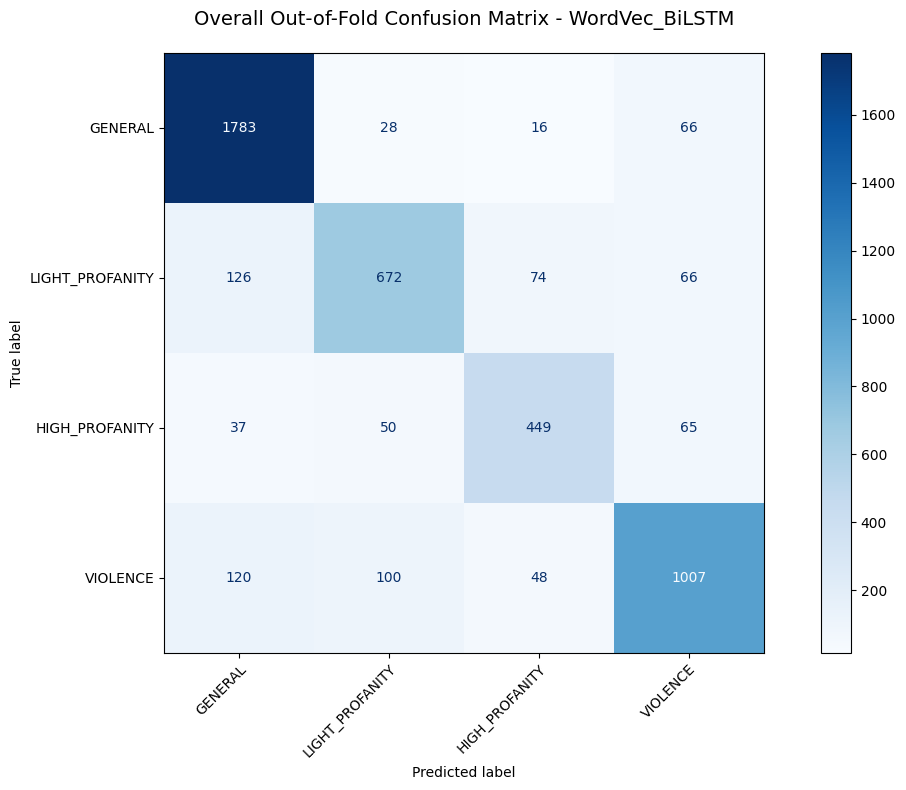

🏃 View run WordVec_BiLSTM at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/d410c43d18684901b8711b1b3adfa208
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2


In [19]:
BiLSTM_cv_outputs = run_cross_validation(architectures_to_test[1], dataset, all_labels, device, label_map, n_splits=5, num_classes=num_classes)

## DNN cross validation


Starting Cross-Validation for: WordVec_DNN
  Applying dataset wrapper: DNNModifiedDataset
Epoch 1/60 | Train Loss: 1.3054 | Val Loss: 1.1165 | Train F1: 0.3231 | Val F1: 0.4537
Epoch 2/60 | Train Loss: 1.1232 | Val Loss: 0.9998 | Train F1: 0.4329 | Val F1: 0.4985
Epoch 3/60 | Train Loss: 1.0464 | Val Loss: 0.9252 | Train F1: 0.4600 | Val F1: 0.5118
Epoch 4/60 | Train Loss: 0.9933 | Val Loss: 0.8583 | Train F1: 0.4824 | Val F1: 0.5507
Epoch 5/60 | Train Loss: 0.9551 | Val Loss: 0.8250 | Train F1: 0.5101 | Val F1: 0.6145
Epoch 6/60 | Train Loss: 0.9259 | Val Loss: 0.8096 | Train F1: 0.5562 | Val F1: 0.6451
Epoch 7/60 | Train Loss: 0.9065 | Val Loss: 0.7814 | Train F1: 0.5575 | Val F1: 0.6809
Epoch 8/60 | Train Loss: 0.8855 | Val Loss: 0.7775 | Train F1: 0.5847 | Val F1: 0.6652
Epoch 9/60 | Train Loss: 0.8640 | Val Loss: 0.7407 | Train F1: 0.5857 | Val F1: 0.6683
Epoch 10/60 | Train Loss: 0.8578 | Val Loss: 0.7141 | Train F1: 0.6009 | Val F1: 0.7018
Epoch 11/60 | Train Loss: 0.8528 | Val

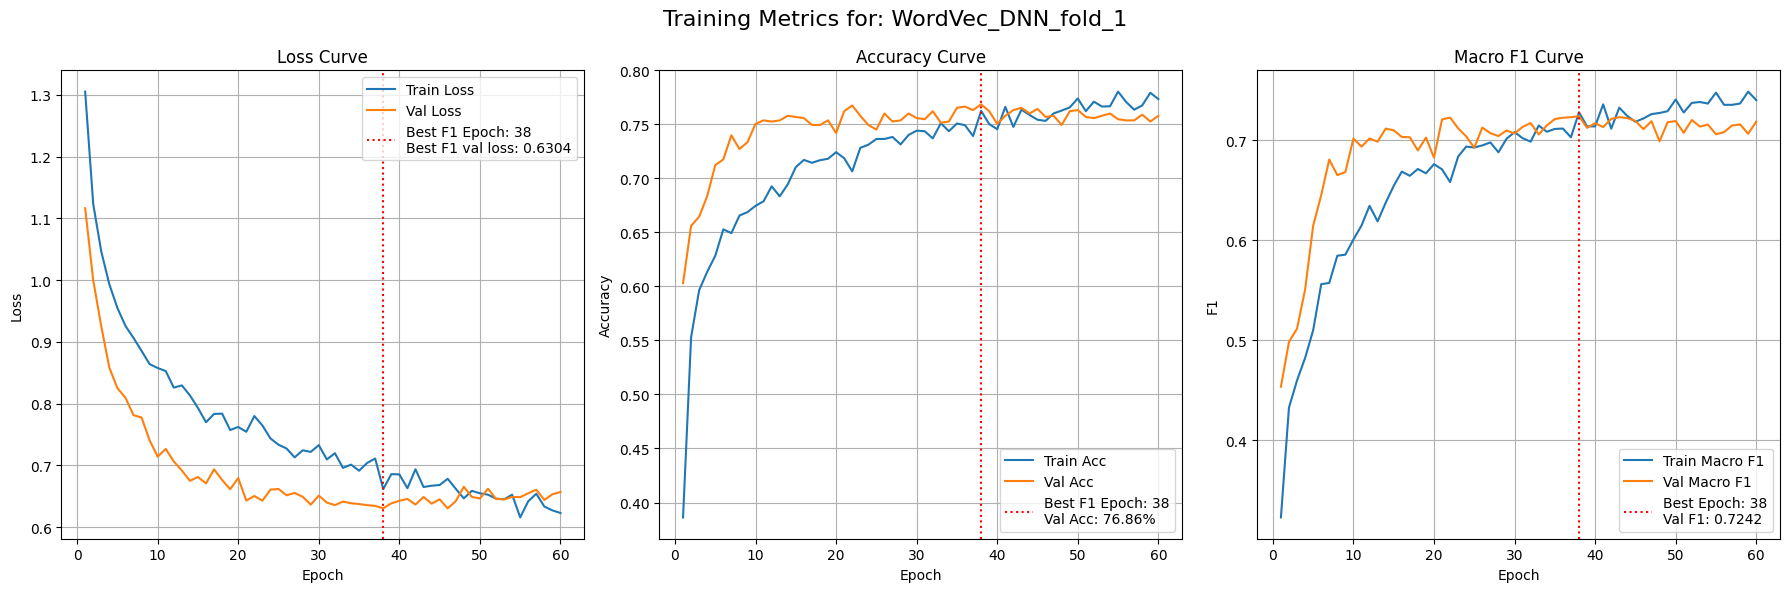

  Logging Fold 1 results under run_id: e1d75eff45ac4cca8760baf92d517c02
  Logged best model for Fold 1 to artifacts/model_weights//kaggle/working/models/WordVec_DNN_fold_1_state_dict.pt
Matthews correlation coefficient: 0.670375087130469
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.80      0.90      0.85       379
LIGHT_PROFANITY       0.72      0.57      0.64       188
 HIGH_PROFANITY       0.64      0.57      0.61       120
       VIOLENCE       0.80      0.81      0.80       255

       accuracy                           0.77       942
      macro avg       0.74      0.71      0.72       942
   weighted avg       0.76      0.77      0.76       942

PR curve will be saved as WordVec_DNN_fold_1_PR.png


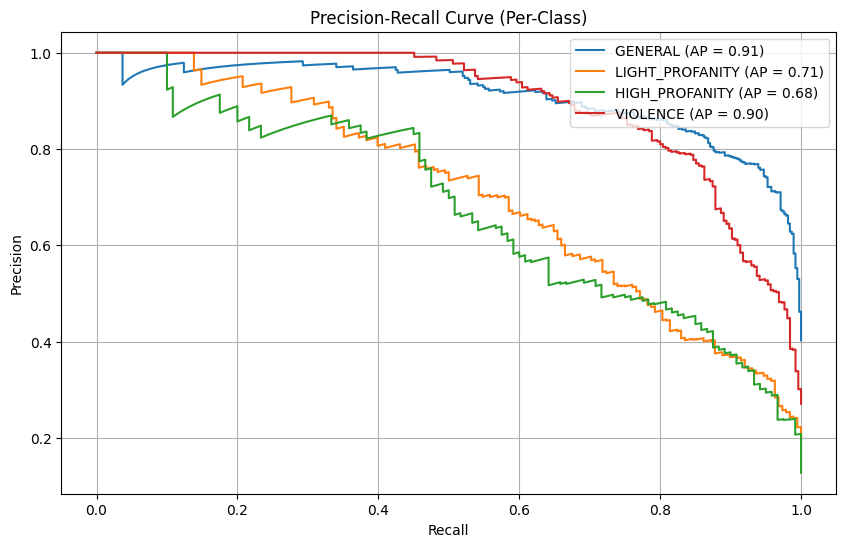

Confusion Matrix will be saved as WordVec_DNN_fold_1_cm.png


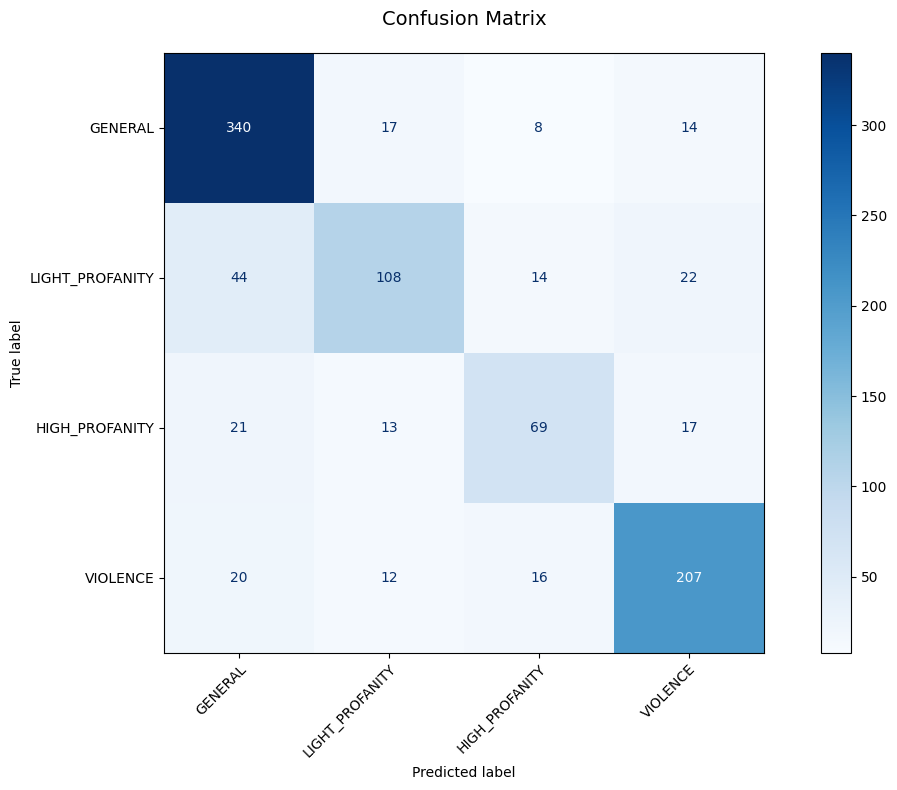

  Logged evaluation plots for Fold 1
🏃 View run Fold 1 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/e1d75eff45ac4cca8760baf92d517c02
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2
Epoch 1/60 | Train Loss: 1.2932 | Val Loss: 1.1043 | Train F1: 0.3470 | Val F1: 0.4350
Epoch 2/60 | Train Loss: 1.1093 | Val Loss: 0.9743 | Train F1: 0.4229 | Val F1: 0.4878
Epoch 3/60 | Train Loss: 1.0360 | Val Loss: 0.9098 | Train F1: 0.4604 | Val F1: 0.5410
Epoch 4/60 | Train Loss: 0.9895 | Val Loss: 0.8672 | Train F1: 0.4792 | Val F1: 0.5515
Epoch 5/60 | Train Loss: 0.9448 | Val Loss: 0.8449 | Train F1: 0.5106 | Val F1: 0.6082
Epoch 6/60 | Train Loss: 0.9239 | Val Loss: 0.8002 | Train F1: 0.5442 | Val F1: 0.6170
Epoch 7/60 | Train Loss: 0.9024 | Val Loss: 0.7824 | Train F1: 0.5646 | Val F1: 0.6210
Epoch 8/60 | Train Loss: 0.8714 | Val Loss: 0.7642 | Train F1: 0.5687 | Val F1: 0.6524
Epoch 9/60 | Train Loss: 0.8872 | Val Loss: 0.760

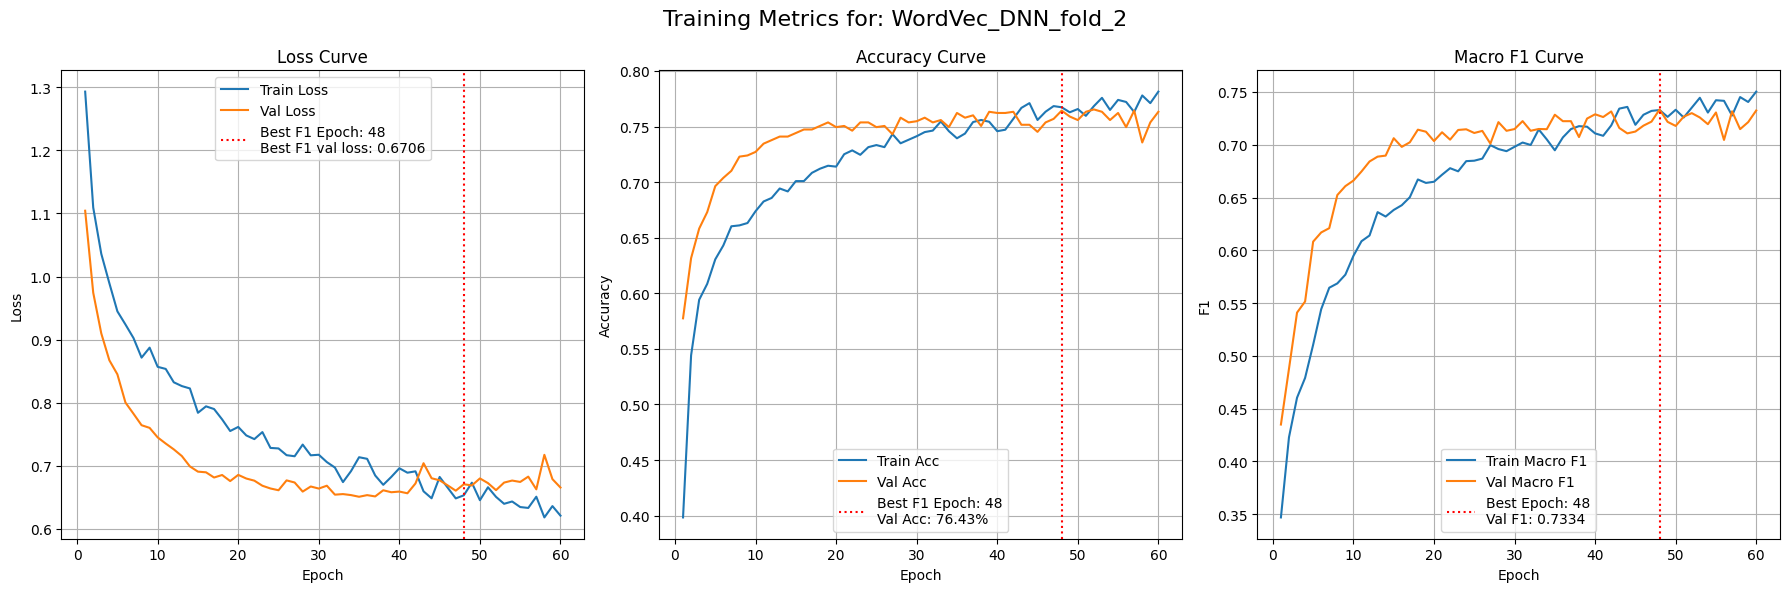

  Logging Fold 2 results under run_id: 4d7a268c593743eca0f207a8621bc1b6
  Logged best model for Fold 2 to artifacts/model_weights//kaggle/working/models/WordVec_DNN_fold_2_state_dict.pt
Matthews correlation coefficient: 0.6655031107457292
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.77      0.90      0.83       379
LIGHT_PROFANITY       0.66      0.56      0.61       187
 HIGH_PROFANITY       0.71      0.69      0.70       121
       VIOLENCE       0.86      0.75      0.80       255

       accuracy                           0.76       942
      macro avg       0.75      0.73      0.73       942
   weighted avg       0.76      0.76      0.76       942

PR curve will be saved as WordVec_DNN_fold_2_PR.png


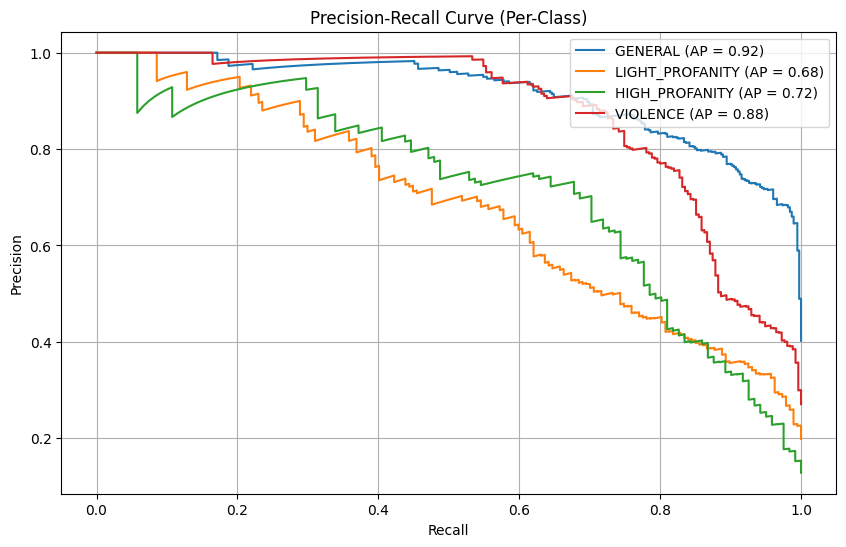

Confusion Matrix will be saved as WordVec_DNN_fold_2_cm.png


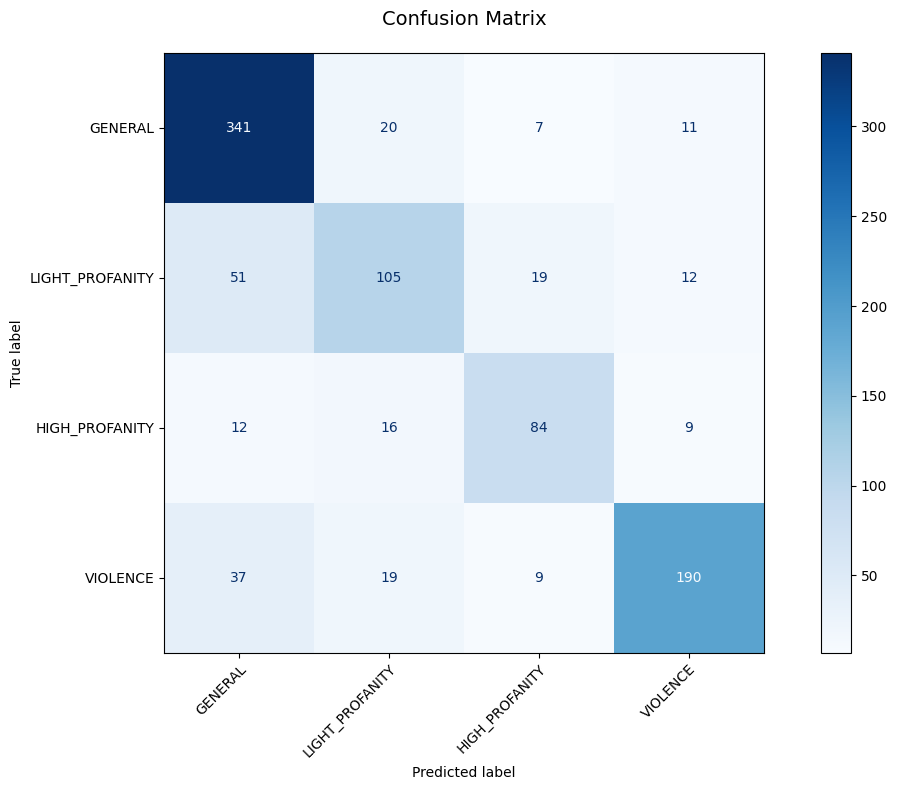

  Logged evaluation plots for Fold 2
🏃 View run Fold 2 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/4d7a268c593743eca0f207a8621bc1b6
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2
Epoch 1/60 | Train Loss: 1.3171 | Val Loss: 1.1546 | Train F1: 0.3476 | Val F1: 0.4775
Epoch 2/60 | Train Loss: 1.1271 | Val Loss: 1.0136 | Train F1: 0.4485 | Val F1: 0.5149
Epoch 3/60 | Train Loss: 1.0311 | Val Loss: 0.9456 | Train F1: 0.4871 | Val F1: 0.5340
Epoch 4/60 | Train Loss: 0.9878 | Val Loss: 0.9007 | Train F1: 0.4974 | Val F1: 0.5740
Epoch 5/60 | Train Loss: 0.9647 | Val Loss: 0.8714 | Train F1: 0.5255 | Val F1: 0.6086
Epoch 6/60 | Train Loss: 0.9230 | Val Loss: 0.8205 | Train F1: 0.5409 | Val F1: 0.6115
Epoch 7/60 | Train Loss: 0.8981 | Val Loss: 0.8201 | Train F1: 0.5681 | Val F1: 0.6374
Epoch 8/60 | Train Loss: 0.8674 | Val Loss: 0.7844 | Train F1: 0.5988 | Val F1: 0.6450
Epoch 9/60 | Train Loss: 0.8777 | Val Loss: 0.766

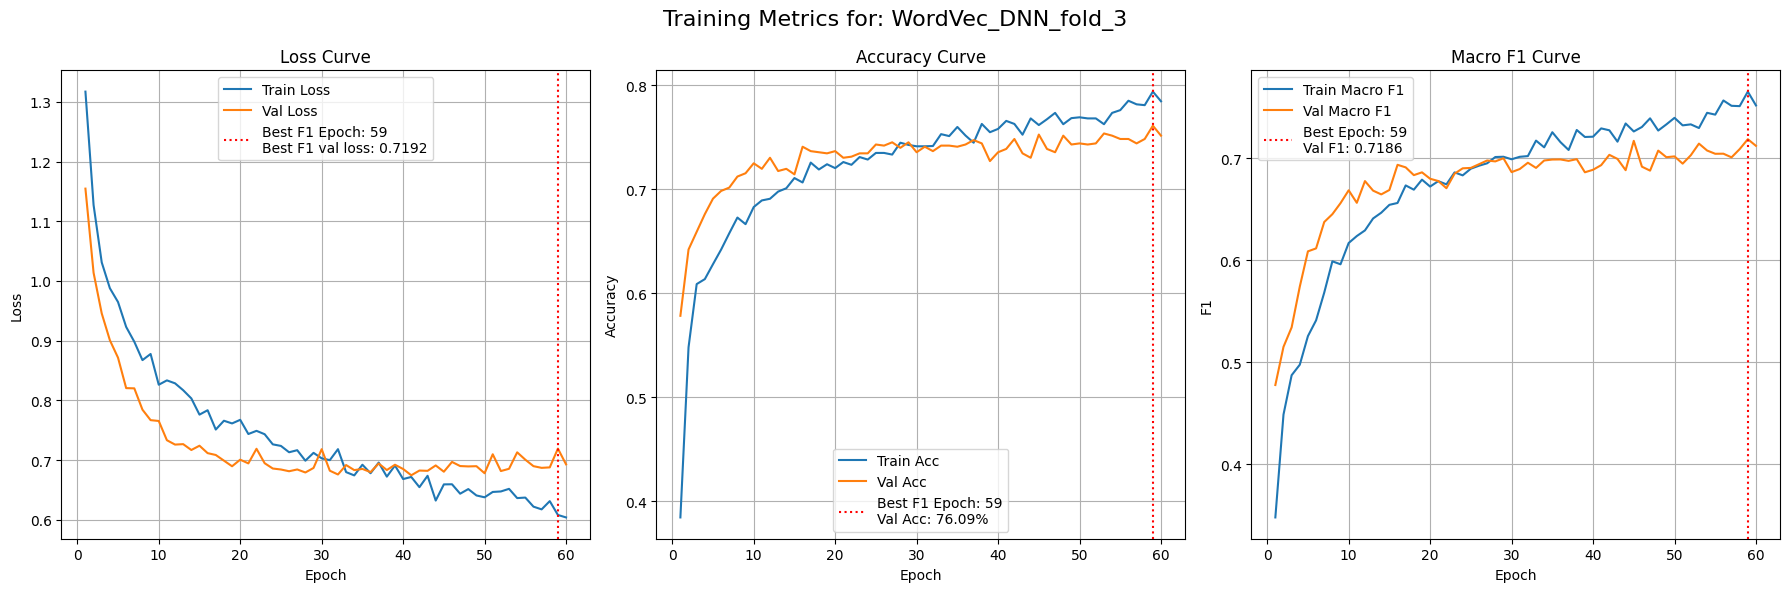

  Logging Fold 3 results under run_id: 47360b9401e44611a6e182e09a87c7bd
  Logged best model for Fold 3 to artifacts/model_weights//kaggle/working/models/WordVec_DNN_fold_3_state_dict.pt
Matthews correlation coefficient: 0.6606890439804278
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.76      0.94      0.84       379
LIGHT_PROFANITY       0.76      0.53      0.62       187
 HIGH_PROFANITY       0.65      0.62      0.64       120
       VIOLENCE       0.81      0.73      0.77       255

       accuracy                           0.76       941
      macro avg       0.75      0.71      0.72       941
   weighted avg       0.76      0.76      0.75       941

PR curve will be saved as WordVec_DNN_fold_3_PR.png


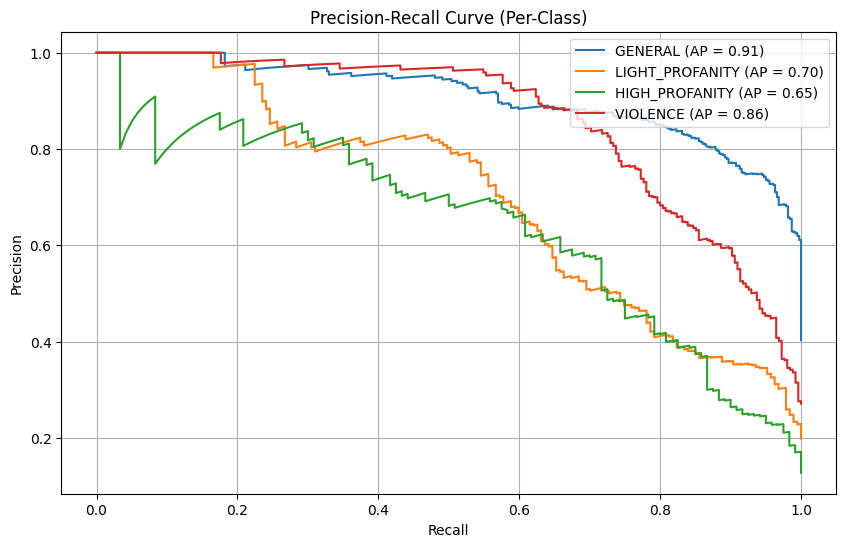

Confusion Matrix will be saved as WordVec_DNN_fold_3_cm.png


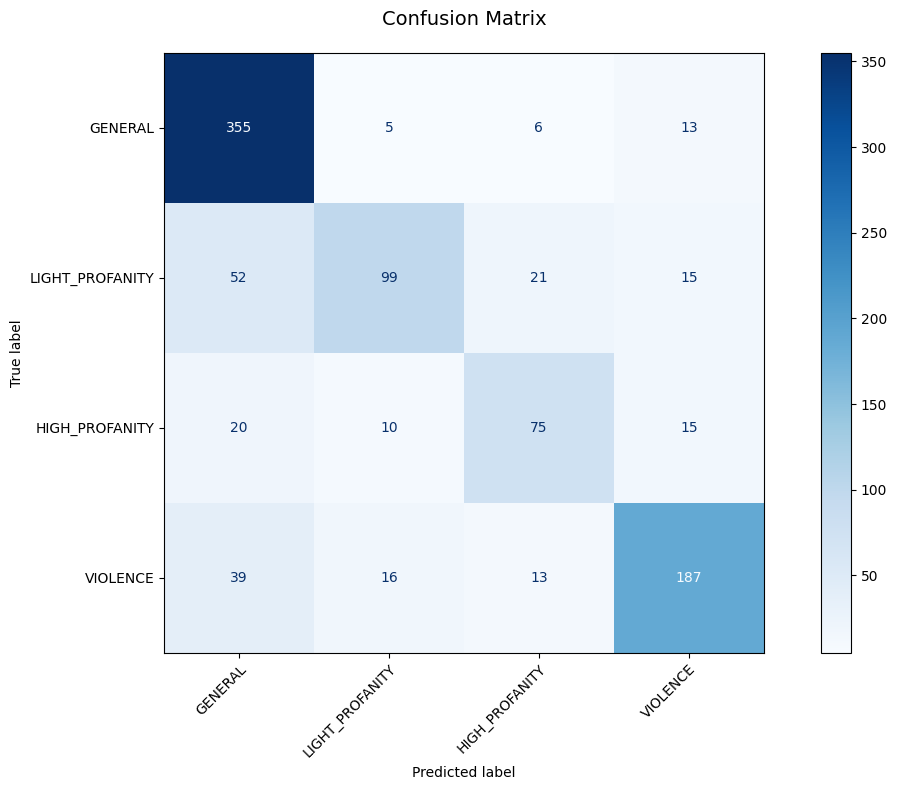

  Logged evaluation plots for Fold 3
🏃 View run Fold 3 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/47360b9401e44611a6e182e09a87c7bd
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2
Epoch 1/60 | Train Loss: 1.3222 | Val Loss: 1.1401 | Train F1: 0.3232 | Val F1: 0.5243
Epoch 2/60 | Train Loss: 1.1231 | Val Loss: 0.9839 | Train F1: 0.4463 | Val F1: 0.5389
Epoch 3/60 | Train Loss: 1.0409 | Val Loss: 0.9253 | Train F1: 0.4774 | Val F1: 0.5950
Epoch 4/60 | Train Loss: 0.9779 | Val Loss: 0.8622 | Train F1: 0.5144 | Val F1: 0.5943
Epoch 5/60 | Train Loss: 0.9523 | Val Loss: 0.8389 | Train F1: 0.5312 | Val F1: 0.6312
Epoch 6/60 | Train Loss: 0.9254 | Val Loss: 0.7900 | Train F1: 0.5443 | Val F1: 0.6361
Epoch 7/60 | Train Loss: 0.9008 | Val Loss: 0.7789 | Train F1: 0.5868 | Val F1: 0.6626
Epoch 8/60 | Train Loss: 0.8813 | Val Loss: 0.7815 | Train F1: 0.5864 | Val F1: 0.6419
Epoch 9/60 | Train Loss: 0.8666 | Val Loss: 0.750

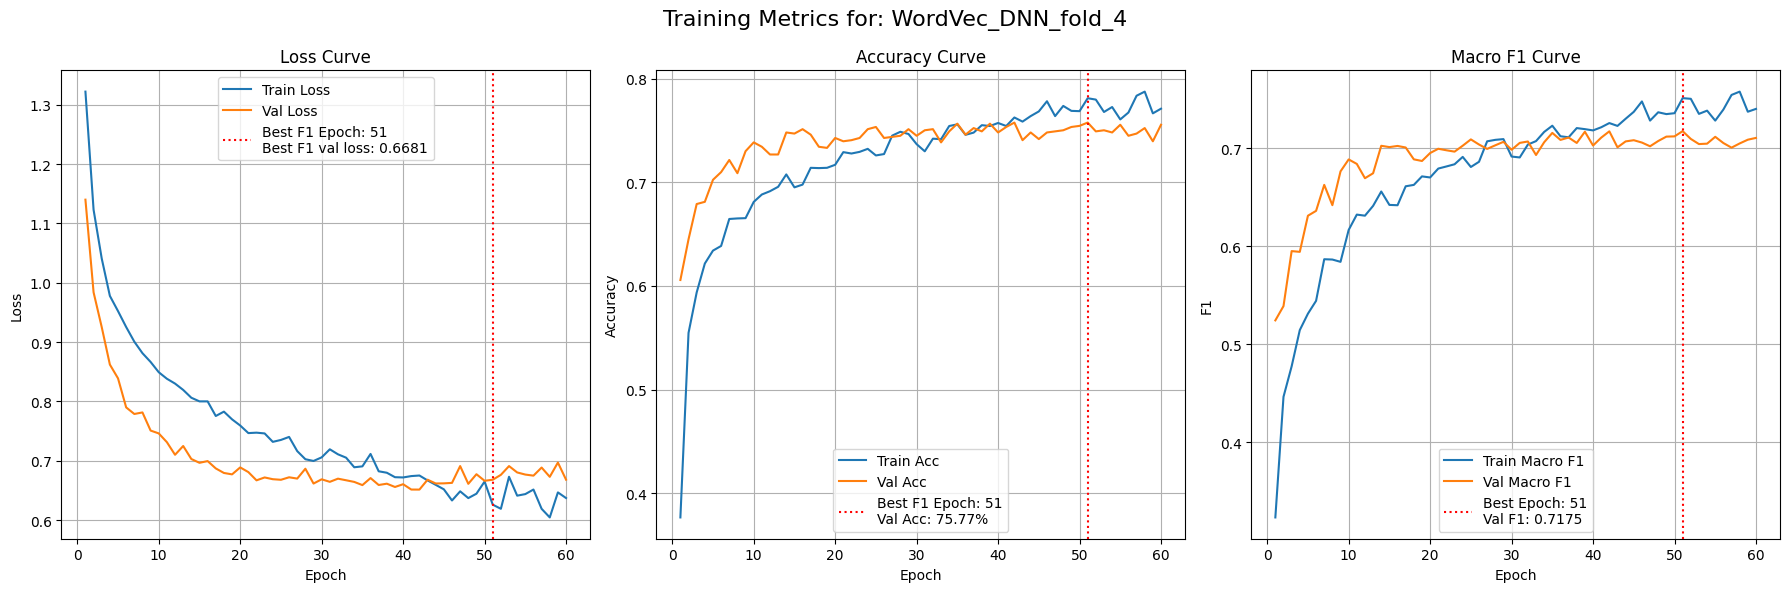

  Logging Fold 4 results under run_id: a7c453b164744f659a50dabf1766573c
  Logged best model for Fold 4 to artifacts/model_weights//kaggle/working/models/WordVec_DNN_fold_4_state_dict.pt
Matthews correlation coefficient: 0.6553706621349991
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.80      0.86      0.83       378
LIGHT_PROFANITY       0.65      0.62      0.64       188
 HIGH_PROFANITY       0.67      0.55      0.60       120
       VIOLENCE       0.80      0.81      0.80       255

       accuracy                           0.76       941
      macro avg       0.73      0.71      0.72       941
   weighted avg       0.75      0.76      0.75       941

PR curve will be saved as WordVec_DNN_fold_4_PR.png


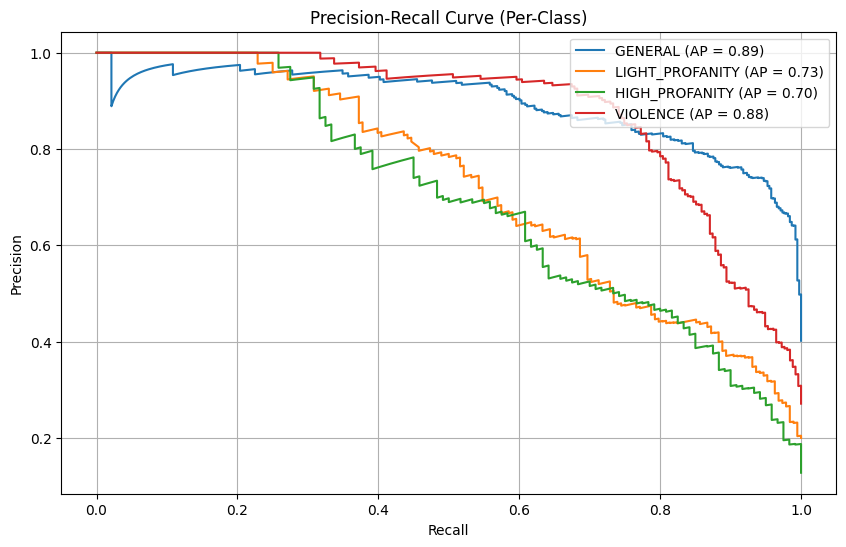

Confusion Matrix will be saved as WordVec_DNN_fold_4_cm.png


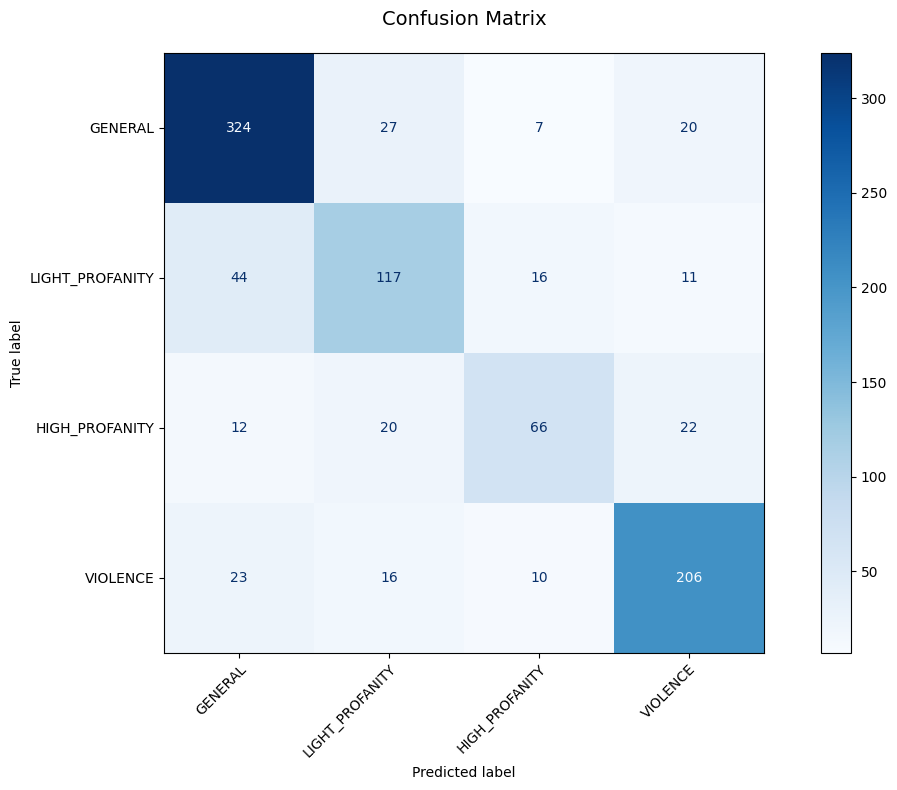

  Logged evaluation plots for Fold 4
🏃 View run Fold 4 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/a7c453b164744f659a50dabf1766573c
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2
Epoch 1/60 | Train Loss: 1.2939 | Val Loss: 1.1453 | Train F1: 0.3101 | Val F1: 0.3824
Epoch 2/60 | Train Loss: 1.1373 | Val Loss: 1.0266 | Train F1: 0.3942 | Val F1: 0.4368
Epoch 3/60 | Train Loss: 1.0397 | Val Loss: 0.9622 | Train F1: 0.4542 | Val F1: 0.4786
Epoch 4/60 | Train Loss: 0.9915 | Val Loss: 0.9142 | Train F1: 0.4691 | Val F1: 0.5220
Epoch 5/60 | Train Loss: 0.9631 | Val Loss: 0.8721 | Train F1: 0.5170 | Val F1: 0.5198
Epoch 6/60 | Train Loss: 0.9304 | Val Loss: 0.8515 | Train F1: 0.5389 | Val F1: 0.5927
Epoch 7/60 | Train Loss: 0.8838 | Val Loss: 0.8329 | Train F1: 0.5621 | Val F1: 0.5902
Epoch 8/60 | Train Loss: 0.8634 | Val Loss: 0.8048 | Train F1: 0.5966 | Val F1: 0.6020
Epoch 9/60 | Train Loss: 0.8480 | Val Loss: 0.798

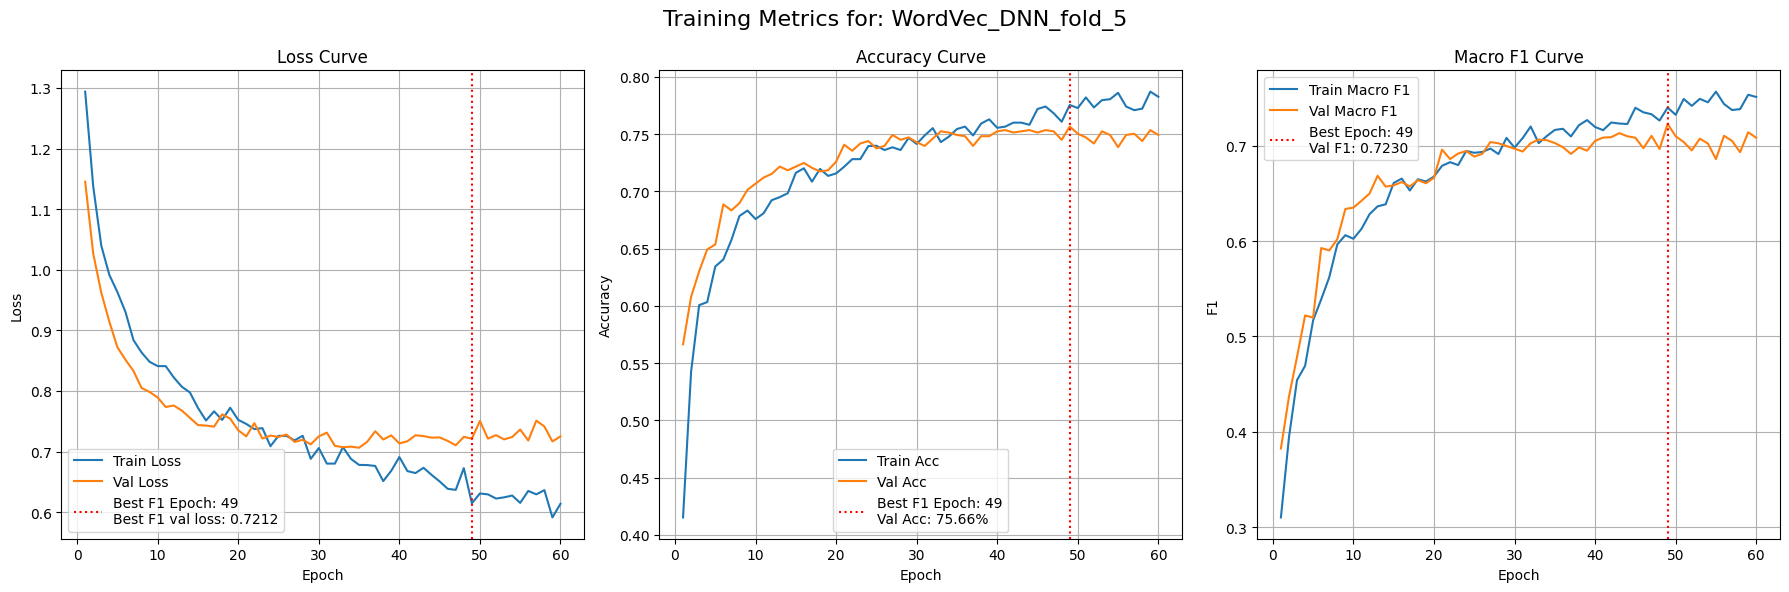

  Logging Fold 5 results under run_id: d6486d288fe44442b403cd0a5f14d751
  Logged best model for Fold 5 to artifacts/model_weights//kaggle/working/models/WordVec_DNN_fold_5_state_dict.pt
Matthews correlation coefficient: 0.6560372418087664
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.84      0.85      0.84       378
LIGHT_PROFANITY       0.62      0.61      0.61       188
 HIGH_PROFANITY       0.68      0.64      0.66       120
       VIOLENCE       0.77      0.79      0.78       255

       accuracy                           0.76       941
      macro avg       0.73      0.72      0.72       941
   weighted avg       0.76      0.76      0.76       941

PR curve will be saved as WordVec_DNN_fold_5_PR.png


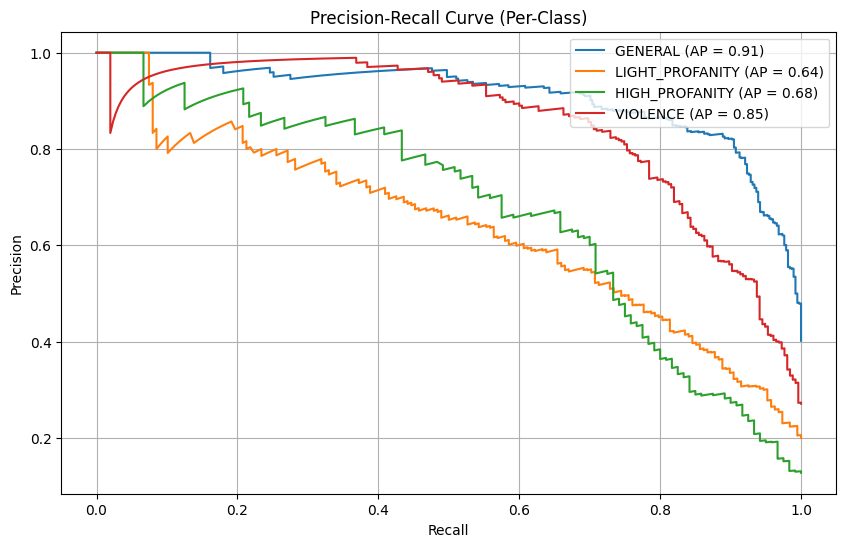

Confusion Matrix will be saved as WordVec_DNN_fold_5_cm.png


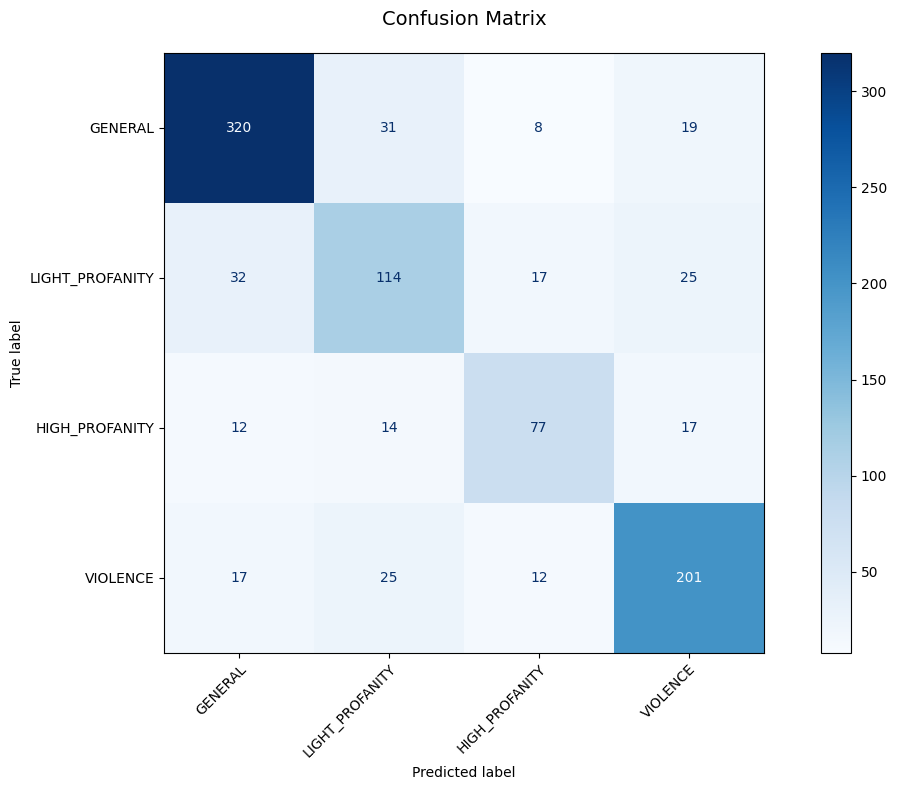

  Logged evaluation plots for Fold 5
🏃 View run Fold 5 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/d6486d288fe44442b403cd0a5f14d751
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2

Aggregating results for WordVec_DNN across 5 folds...
Overall Results for WordVec_DNN:
  Avg Accuracy: 0.7616
  Avg Macro F1: 0.7233
  Avg Macro precision: 0.7379
  Avg Macro recall: 0.7152
  Avg Weighted F1: 0.7573
  Avg MCC: 0.6616

Performing Overall Out-of-Fold Evaluation for WordVec_DNN...
Overall Out-of-Fold Classification Report for WordVec_DNN:
                 precision    recall  f1-score   support

        GENERAL       0.79      0.89      0.84      1893
LIGHT_PROFANITY       0.68      0.58      0.62       938
 HIGH_PROFANITY       0.67      0.62      0.64       601
       VIOLENCE       0.80      0.78      0.79      1275

       accuracy                           0.76      4707
      macro avg       0.74      0.72      0.7

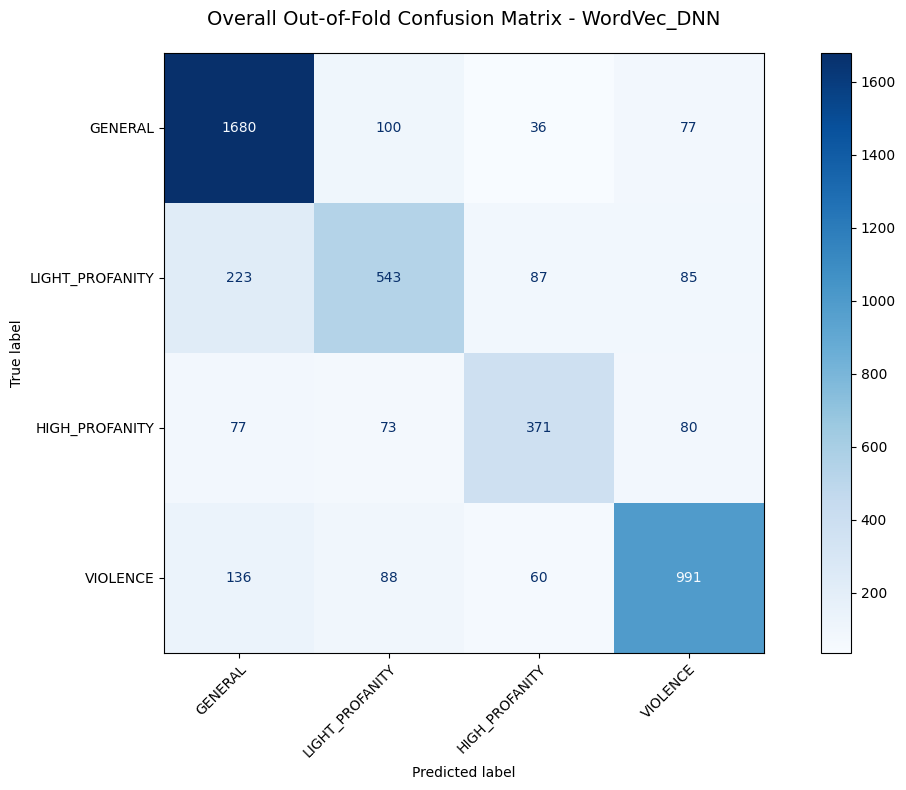

🏃 View run WordVec_DNN at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/48bec15e679541c4bf25e17b3482ddab
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2


In [20]:
dnn_cv_outputs = run_cross_validation(architectures_to_test[2], dataset, all_labels, device, label_map, n_splits=5, num_classes=num_classes)

## Residual BiLSTM cross validation


Starting Cross-Validation for: WordVec_BiLSTM_residual
Epoch 1/20 | Train Loss: 1.3489 | Val Loss: 1.2647 | Train F1: 0.2118 | Val F1: 0.2676
Epoch 2/20 | Train Loss: 1.2121 | Val Loss: 1.0721 | Train F1: 0.3248 | Val F1: 0.3782
Epoch 3/20 | Train Loss: 1.0217 | Val Loss: 0.8851 | Train F1: 0.4658 | Val F1: 0.5139
Epoch 4/20 | Train Loss: 0.8694 | Val Loss: 0.7761 | Train F1: 0.5979 | Val F1: 0.6316
Epoch 5/20 | Train Loss: 0.7693 | Val Loss: 0.6987 | Train F1: 0.6768 | Val F1: 0.7306
Epoch 6/20 | Train Loss: 0.7069 | Val Loss: 0.6916 | Train F1: 0.7339 | Val F1: 0.7406
Epoch 7/20 | Train Loss: 0.6573 | Val Loss: 0.6576 | Train F1: 0.7671 | Val F1: 0.7650
Epoch 8/20 | Train Loss: 0.6216 | Val Loss: 0.6415 | Train F1: 0.7843 | Val F1: 0.7692
Epoch 9/20 | Train Loss: 0.5906 | Val Loss: 0.6333 | Train F1: 0.8098 | Val F1: 0.7865
Epoch 10/20 | Train Loss: 0.5741 | Val Loss: 0.6250 | Train F1: 0.8180 | Val F1: 0.7870
Epoch 11/20 | Train Loss: 0.5530 | Val Loss: 0.6314 | Train F1: 0.8313 | 

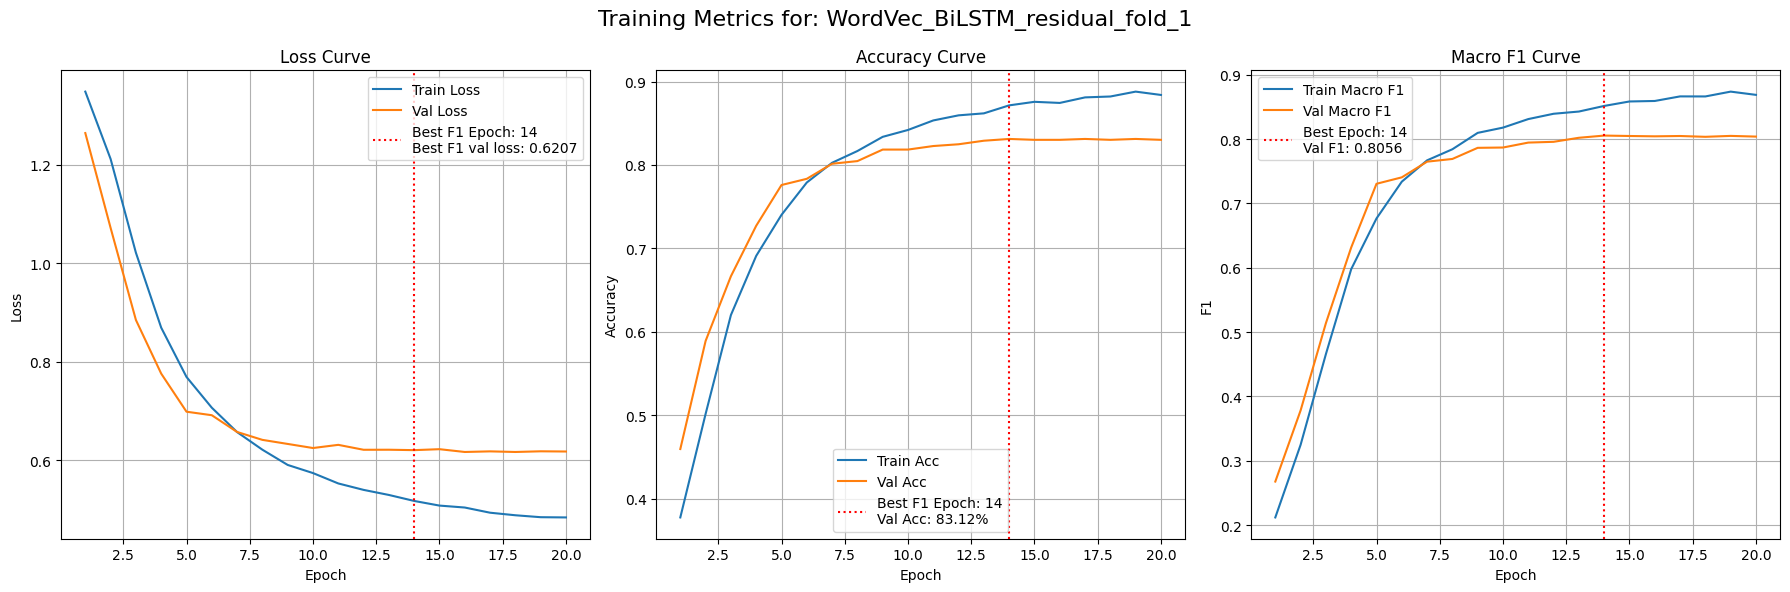

  Logging Fold 1 results under run_id: a6ae514094ed447b8fd7d66b88f03dde
  Logged best model for Fold 1 to artifacts/model_weights//kaggle/working/models/WordVec_BiLSTM_residual_fold_1_state_dict.pt
Matthews correlation coefficient: 0.7604041420597524
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.87      0.94      0.91       379
LIGHT_PROFANITY       0.76      0.69      0.73       188
 HIGH_PROFANITY       0.80      0.75      0.78       120
       VIOLENCE       0.83      0.80      0.82       255

       accuracy                           0.83       942
      macro avg       0.82      0.80      0.81       942
   weighted avg       0.83      0.83      0.83       942

PR curve will be saved as WordVec_BiLSTM_residual_fold_1_PR.png


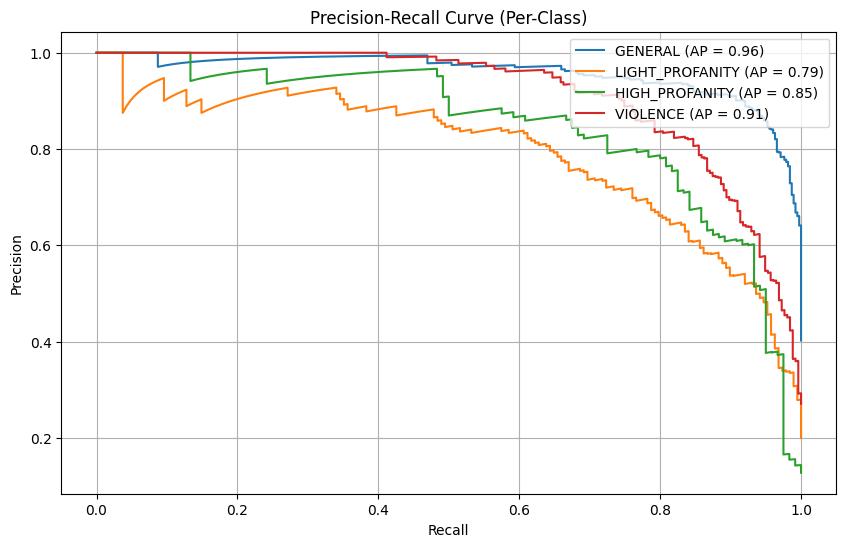

Confusion Matrix will be saved as WordVec_BiLSTM_residual_fold_1_cm.png


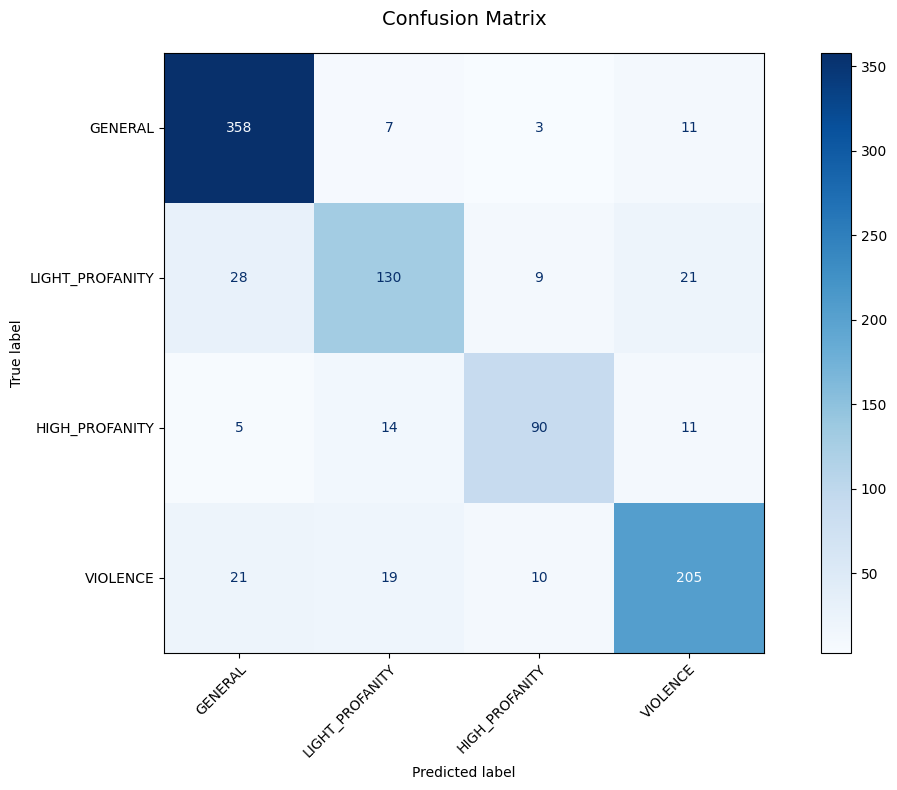

  Logged evaluation plots for Fold 1
🏃 View run Fold 1 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/a6ae514094ed447b8fd7d66b88f03dde
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2
Epoch 1/20 | Train Loss: 1.3357 | Val Loss: 1.2224 | Train F1: 0.2436 | Val F1: 0.2988
Epoch 2/20 | Train Loss: 1.1804 | Val Loss: 1.0229 | Train F1: 0.3653 | Val F1: 0.4143
Epoch 3/20 | Train Loss: 0.9966 | Val Loss: 0.8569 | Train F1: 0.4820 | Val F1: 0.5555
Epoch 4/20 | Train Loss: 0.8624 | Val Loss: 0.7575 | Train F1: 0.6038 | Val F1: 0.7191
Epoch 5/20 | Train Loss: 0.7682 | Val Loss: 0.7046 | Train F1: 0.6901 | Val F1: 0.7377
Epoch 6/20 | Train Loss: 0.7021 | Val Loss: 0.6672 | Train F1: 0.7266 | Val F1: 0.7676
Epoch 7/20 | Train Loss: 0.6610 | Val Loss: 0.6525 | Train F1: 0.7621 | Val F1: 0.7816
Epoch 8/20 | Train Loss: 0.6186 | Val Loss: 0.6415 | Train F1: 0.7913 | Val F1: 0.7906
Epoch 9/20 | Train Loss: 0.5972 | Val Loss: 0.642

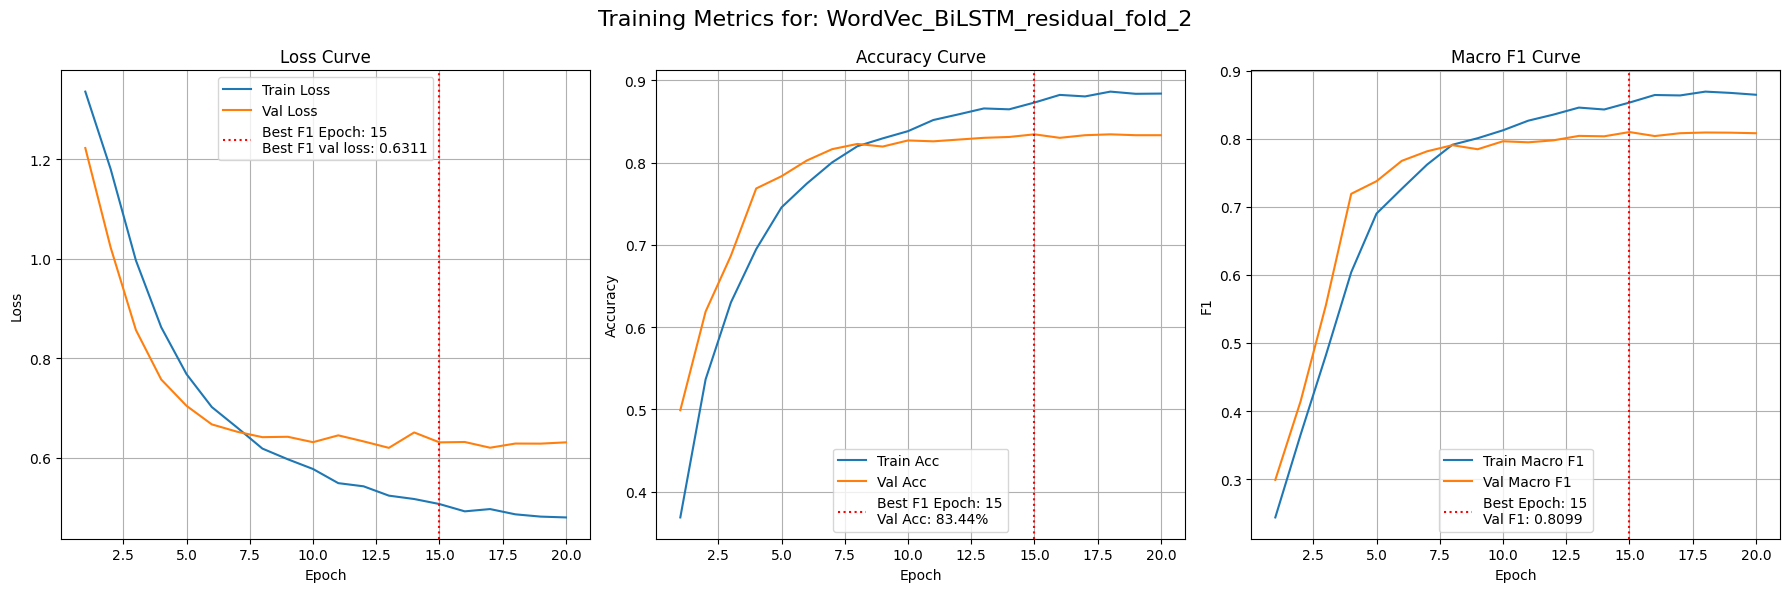

  Logging Fold 2 results under run_id: 102a4f90540d409cb76c02e1288b7ee3
  Logged best model for Fold 2 to artifacts/model_weights//kaggle/working/models/WordVec_BiLSTM_residual_fold_2_state_dict.pt
Matthews correlation coefficient: 0.7655260098182061
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.86      0.95      0.90       379
LIGHT_PROFANITY       0.77      0.66      0.71       187
 HIGH_PROFANITY       0.79      0.79      0.79       121
       VIOLENCE       0.87      0.81      0.84       255

       accuracy                           0.83       942
      macro avg       0.82      0.80      0.81       942
   weighted avg       0.83      0.83      0.83       942

PR curve will be saved as WordVec_BiLSTM_residual_fold_2_PR.png


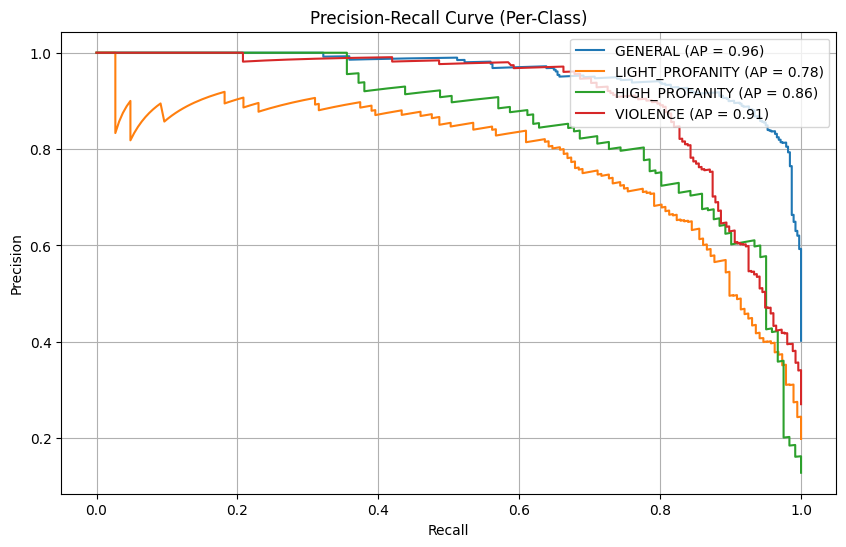

Confusion Matrix will be saved as WordVec_BiLSTM_residual_fold_2_cm.png


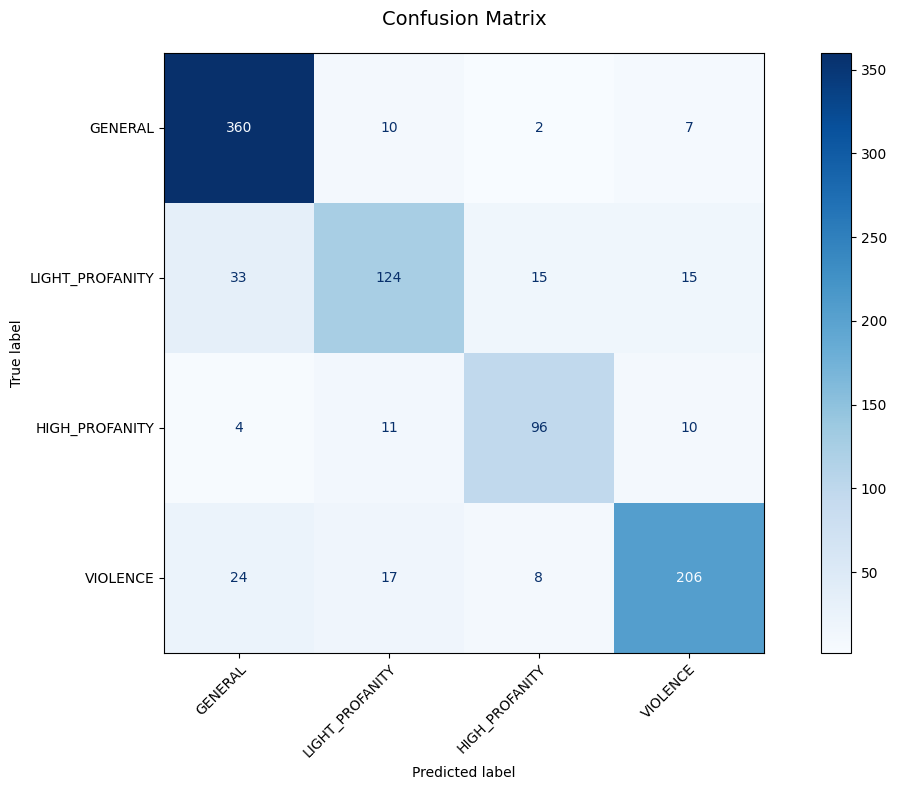

  Logged evaluation plots for Fold 2
🏃 View run Fold 2 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/102a4f90540d409cb76c02e1288b7ee3
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2
Epoch 1/20 | Train Loss: 1.3986 | Val Loss: 1.2215 | Train F1: 0.2901 | Val F1: 0.3425
Epoch 2/20 | Train Loss: 1.1580 | Val Loss: 1.0274 | Train F1: 0.3720 | Val F1: 0.4166
Epoch 3/20 | Train Loss: 0.9980 | Val Loss: 0.9146 | Train F1: 0.4609 | Val F1: 0.4983
Epoch 4/20 | Train Loss: 0.8822 | Val Loss: 0.8367 | Train F1: 0.5569 | Val F1: 0.5773
Epoch 5/20 | Train Loss: 0.7898 | Val Loss: 0.7650 | Train F1: 0.6560 | Val F1: 0.6686
Epoch 6/20 | Train Loss: 0.7133 | Val Loss: 0.7109 | Train F1: 0.7265 | Val F1: 0.7251
Epoch 7/20 | Train Loss: 0.6562 | Val Loss: 0.6857 | Train F1: 0.7703 | Val F1: 0.7391
Epoch 8/20 | Train Loss: 0.6214 | Val Loss: 0.6749 | Train F1: 0.7830 | Val F1: 0.7474
Epoch 9/20 | Train Loss: 0.5896 | Val Loss: 0.661

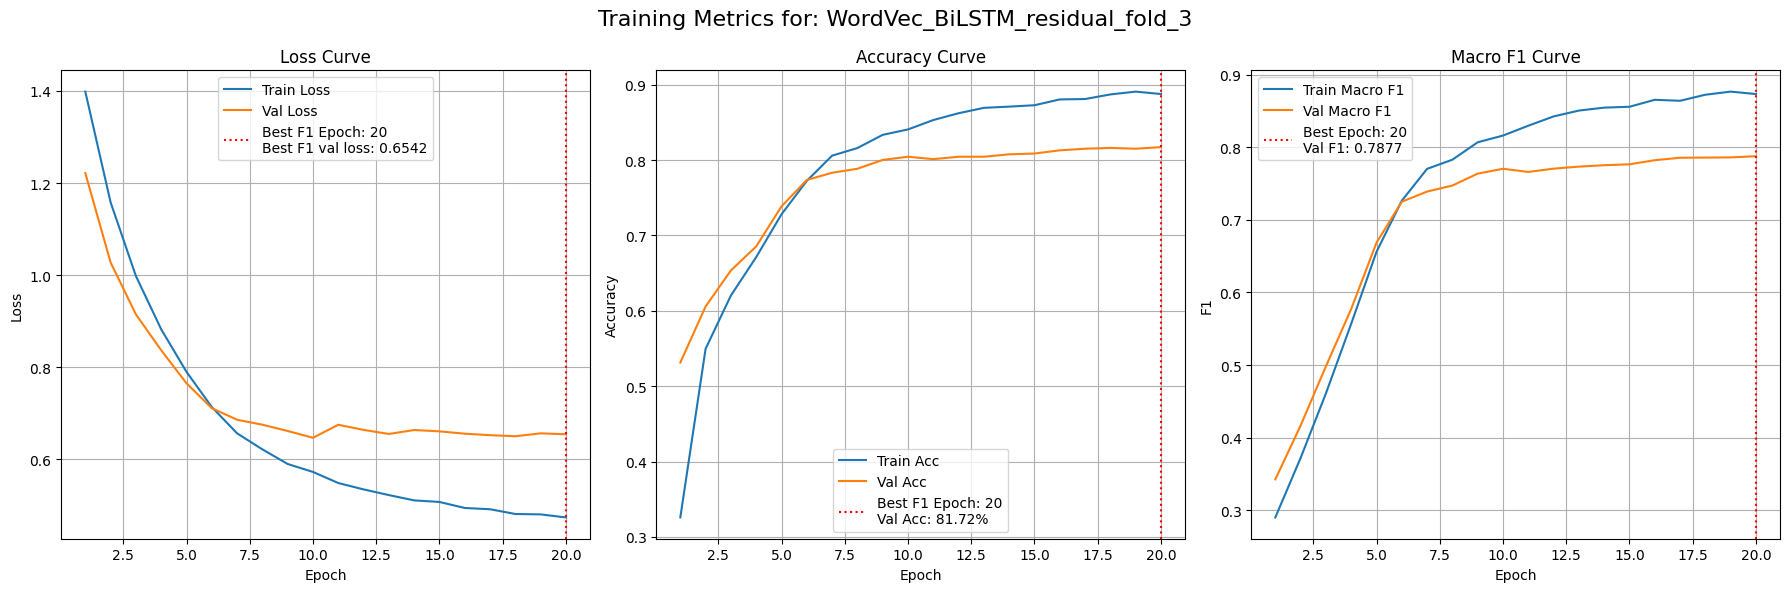

  Logging Fold 3 results under run_id: 9575a49f2a3046f1831a5ab685e9db03
  Logged best model for Fold 3 to artifacts/model_weights//kaggle/working/models/WordVec_BiLSTM_residual_fold_3_state_dict.pt
Matthews correlation coefficient: 0.7413788042627008
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.85      0.95      0.90       379
LIGHT_PROFANITY       0.74      0.70      0.72       187
 HIGH_PROFANITY       0.74      0.74      0.74       120
       VIOLENCE       0.85      0.75      0.80       255

       accuracy                           0.82       941
      macro avg       0.80      0.78      0.79       941
   weighted avg       0.82      0.82      0.81       941

PR curve will be saved as WordVec_BiLSTM_residual_fold_3_PR.png


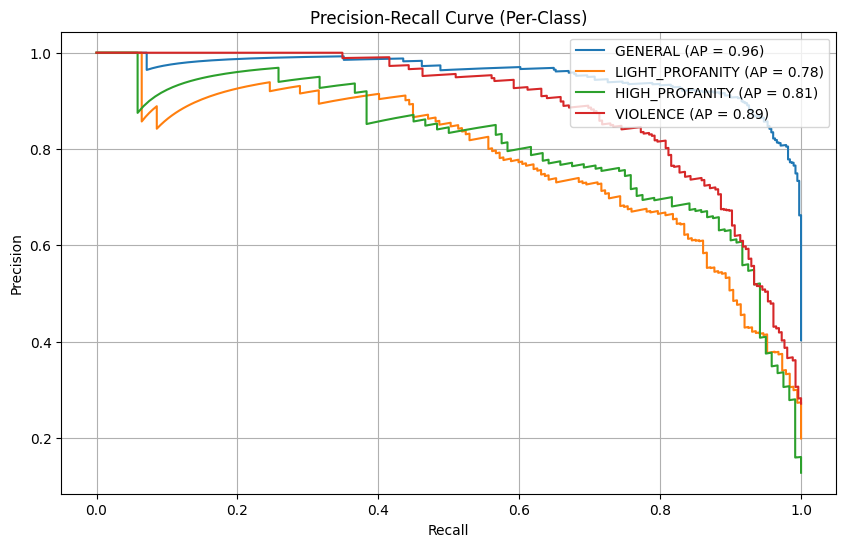

Confusion Matrix will be saved as WordVec_BiLSTM_residual_fold_3_cm.png


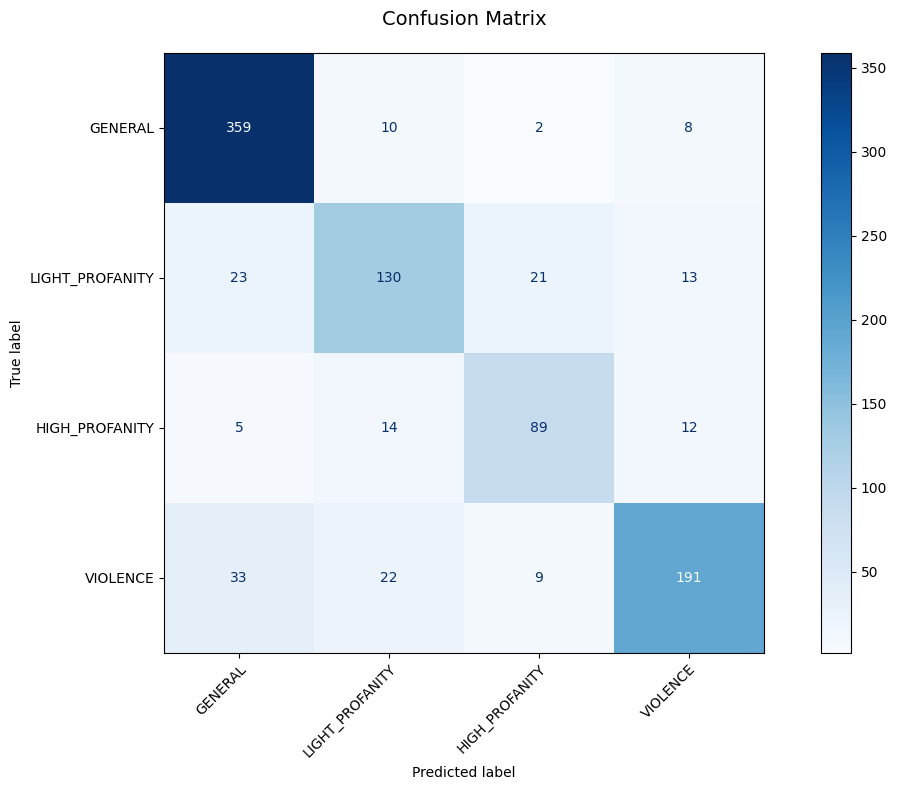

  Logged evaluation plots for Fold 3
🏃 View run Fold 3 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/9575a49f2a3046f1831a5ab685e9db03
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2
Epoch 1/20 | Train Loss: 1.3277 | Val Loss: 1.2325 | Train F1: 0.2754 | Val F1: 0.2797
Epoch 2/20 | Train Loss: 1.1540 | Val Loss: 1.0219 | Train F1: 0.3686 | Val F1: 0.3913
Epoch 3/20 | Train Loss: 0.9765 | Val Loss: 0.8866 | Train F1: 0.4901 | Val F1: 0.5889
Epoch 4/20 | Train Loss: 0.8499 | Val Loss: 0.7720 | Train F1: 0.6154 | Val F1: 0.6671
Epoch 5/20 | Train Loss: 0.7520 | Val Loss: 0.7058 | Train F1: 0.7020 | Val F1: 0.7339
Epoch 6/20 | Train Loss: 0.6788 | Val Loss: 0.6879 | Train F1: 0.7510 | Val F1: 0.7477
Epoch 7/20 | Train Loss: 0.6382 | Val Loss: 0.6577 | Train F1: 0.7819 | Val F1: 0.7698
Epoch 8/20 | Train Loss: 0.6048 | Val Loss: 0.6614 | Train F1: 0.7923 | Val F1: 0.7737
Epoch 9/20 | Train Loss: 0.5785 | Val Loss: 0.642

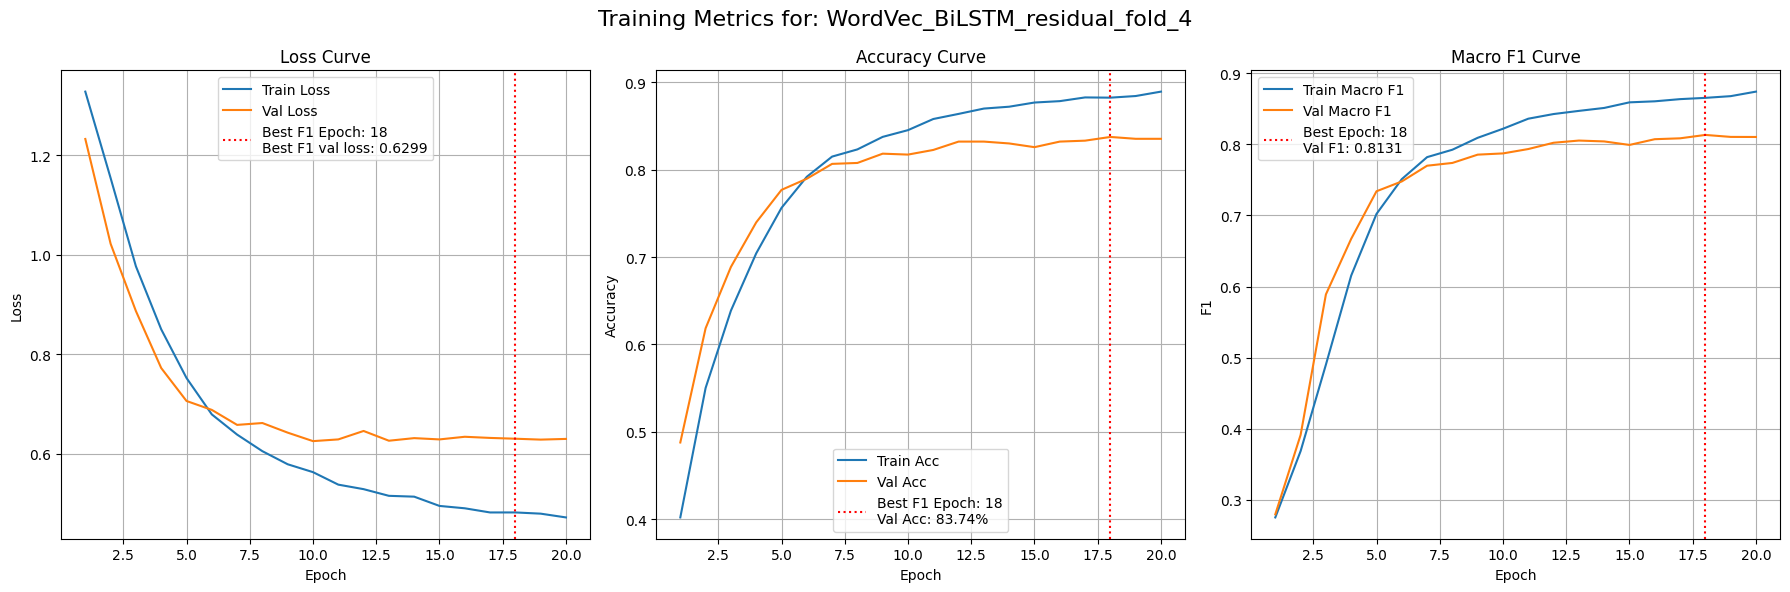

  Logging Fold 4 results under run_id: a3a1706d501849029103da6b54734e01
  Logged best model for Fold 4 to artifacts/model_weights//kaggle/working/models/WordVec_BiLSTM_residual_fold_4_state_dict.pt
Matthews correlation coefficient: 0.7705357975402529
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.86      0.94      0.90       378
LIGHT_PROFANITY       0.77      0.70      0.73       188
 HIGH_PROFANITY       0.74      0.80      0.77       120
       VIOLENCE       0.90      0.81      0.85       255

       accuracy                           0.84       941
      macro avg       0.82      0.81      0.81       941
   weighted avg       0.84      0.84      0.84       941

PR curve will be saved as WordVec_BiLSTM_residual_fold_4_PR.png


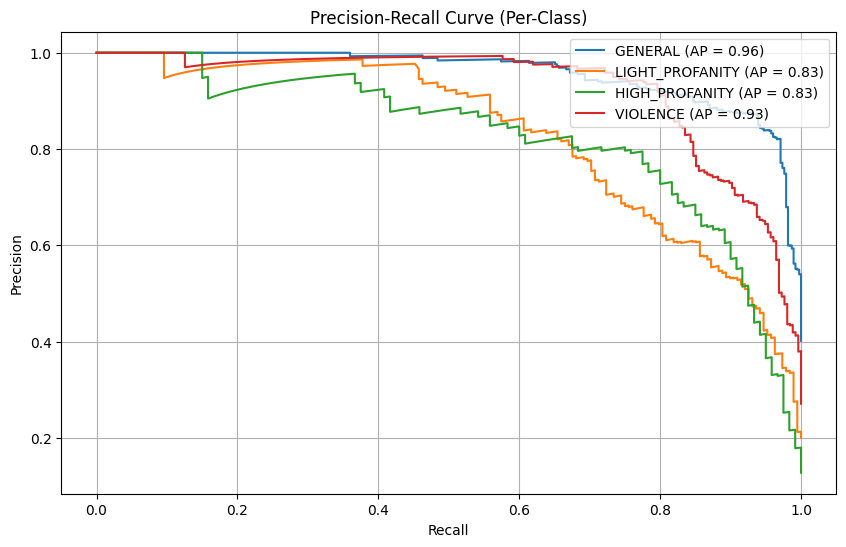

Confusion Matrix will be saved as WordVec_BiLSTM_residual_fold_4_cm.png


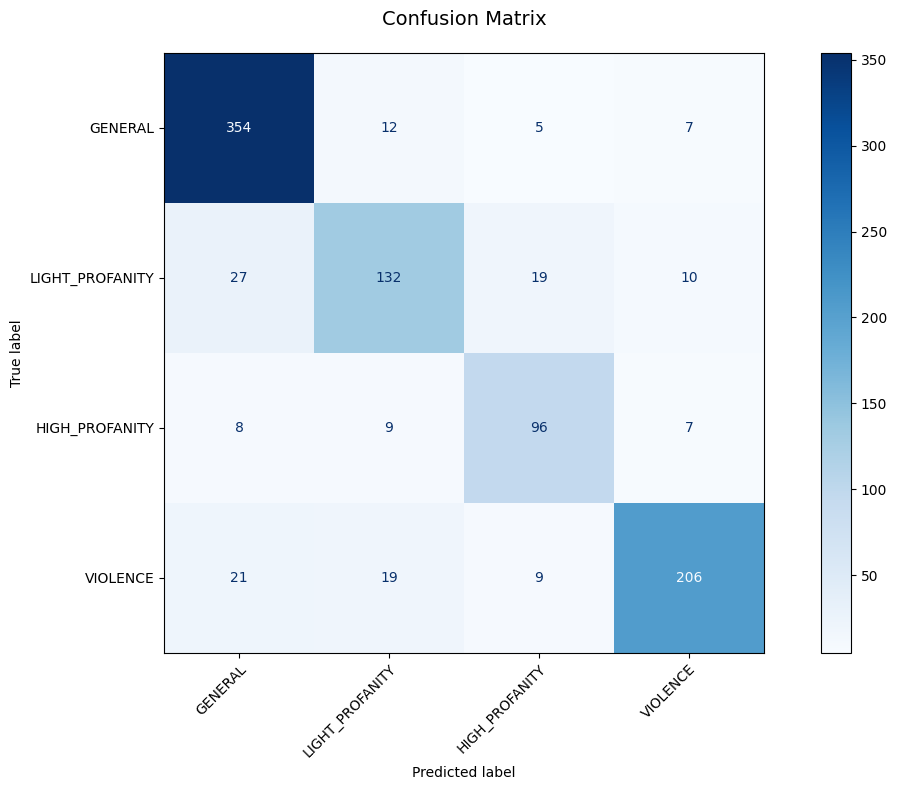

  Logged evaluation plots for Fold 4
🏃 View run Fold 4 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/a3a1706d501849029103da6b54734e01
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2
Epoch 1/20 | Train Loss: 1.3775 | Val Loss: 1.2708 | Train F1: 0.2216 | Val F1: 0.2635
Epoch 2/20 | Train Loss: 1.1940 | Val Loss: 1.0778 | Train F1: 0.3385 | Val F1: 0.3684
Epoch 3/20 | Train Loss: 1.0221 | Val Loss: 0.9161 | Train F1: 0.4479 | Val F1: 0.4677
Epoch 4/20 | Train Loss: 0.8668 | Val Loss: 0.8057 | Train F1: 0.5921 | Val F1: 0.6444
Epoch 5/20 | Train Loss: 0.7603 | Val Loss: 0.7572 | Train F1: 0.6892 | Val F1: 0.6916
Epoch 6/20 | Train Loss: 0.6837 | Val Loss: 0.7312 | Train F1: 0.7565 | Val F1: 0.7284
Epoch 7/20 | Train Loss: 0.6339 | Val Loss: 0.7288 | Train F1: 0.7800 | Val F1: 0.7340
Epoch 8/20 | Train Loss: 0.5980 | Val Loss: 0.7077 | Train F1: 0.8009 | Val F1: 0.7613
Epoch 9/20 | Train Loss: 0.5756 | Val Loss: 0.711

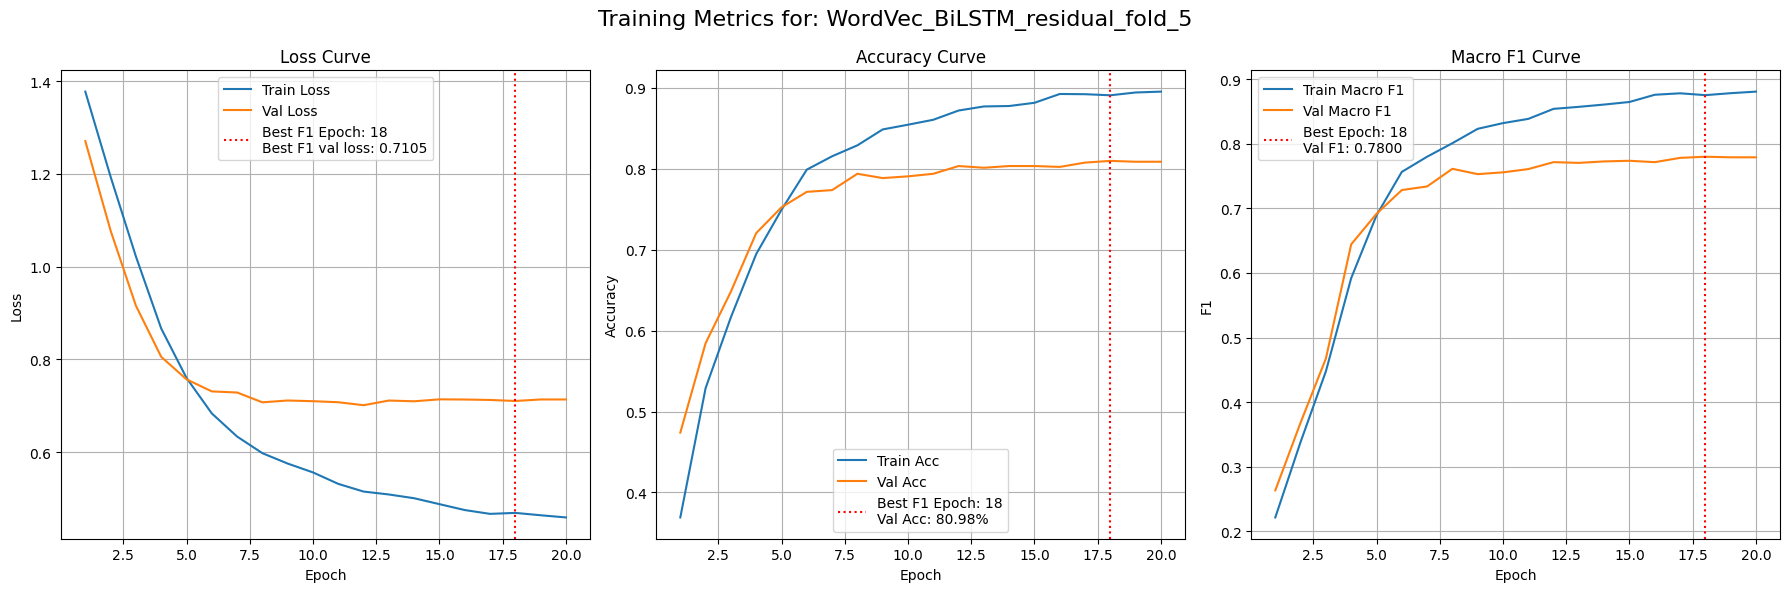

  Logging Fold 5 results under run_id: 02c462214ba64839a885314eff8e0888
  Logged best model for Fold 5 to artifacts/model_weights//kaggle/working/models/WordVec_BiLSTM_residual_fold_5_state_dict.pt
Matthews correlation coefficient: 0.7307706824717777
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.86      0.93      0.89       378
LIGHT_PROFANITY       0.76      0.68      0.72       188
 HIGH_PROFANITY       0.70      0.73      0.72       120
       VIOLENCE       0.82      0.77      0.79       255

       accuracy                           0.81       941
      macro avg       0.79      0.78      0.78       941
   weighted avg       0.81      0.81      0.81       941

PR curve will be saved as WordVec_BiLSTM_residual_fold_5_PR.png


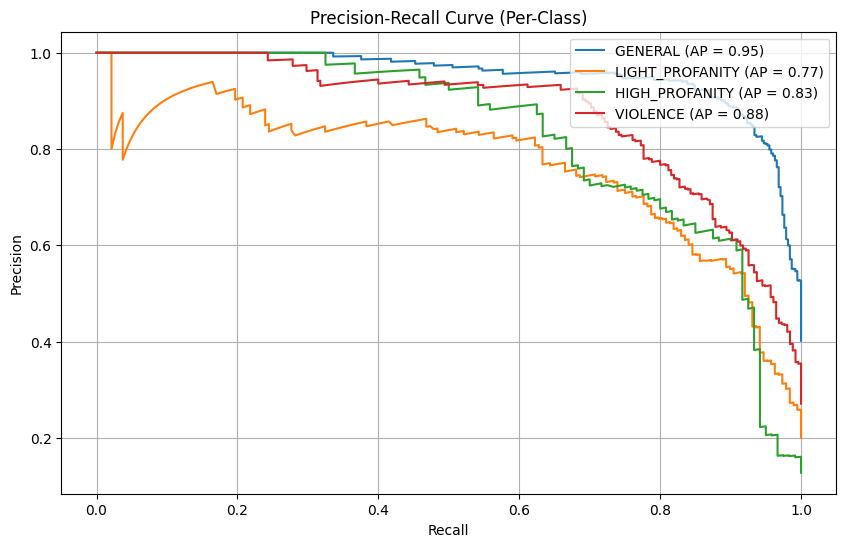

Confusion Matrix will be saved as WordVec_BiLSTM_residual_fold_5_cm.png


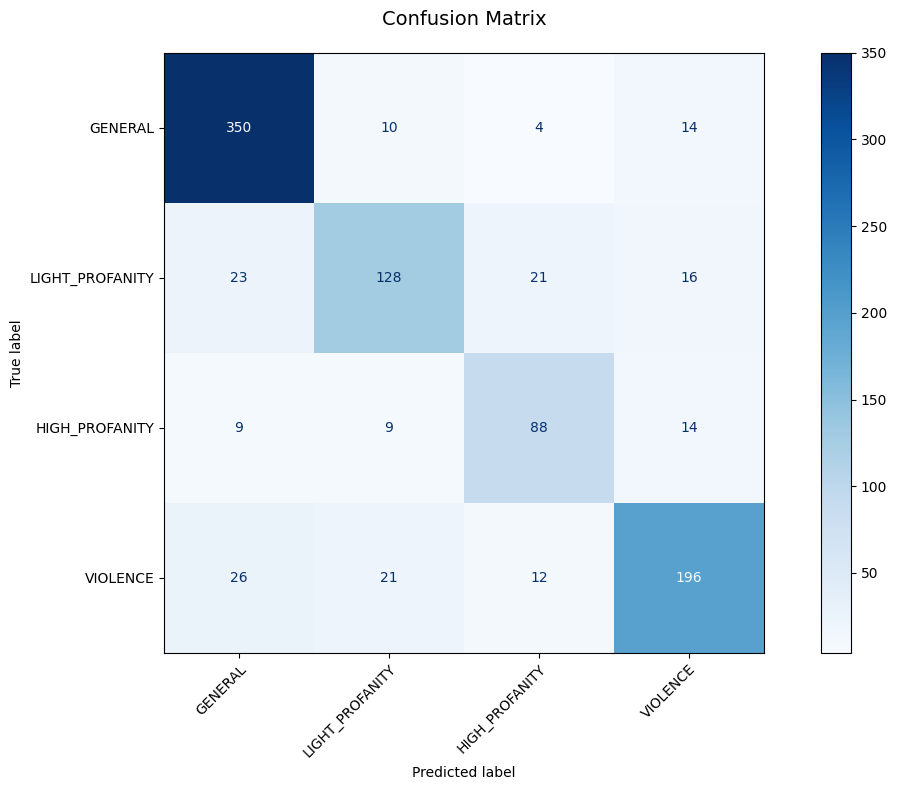

  Logged evaluation plots for Fold 5
🏃 View run Fold 5 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/02c462214ba64839a885314eff8e0888
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2

Aggregating results for WordVec_BiLSTM_residual across 5 folds...
Overall Results for WordVec_BiLSTM_residual:
  Avg Accuracy: 0.8260
  Avg Macro F1: 0.7993
  Avg Macro precision: 0.8068
  Avg Macro recall: 0.7946
  Avg Weighted F1: 0.8236
  Avg MCC: 0.7537

Performing Overall Out-of-Fold Evaluation for WordVec_BiLSTM_residual...
Overall Out-of-Fold Classification Report for WordVec_BiLSTM_residual:
                 precision    recall  f1-score   support

        GENERAL       0.86      0.94      0.90      1893
LIGHT_PROFANITY       0.76      0.69      0.72       938
 HIGH_PROFANITY       0.75      0.76      0.76       601
       VIOLENCE       0.85      0.79      0.82      1275

       accuracy                           0.83      47

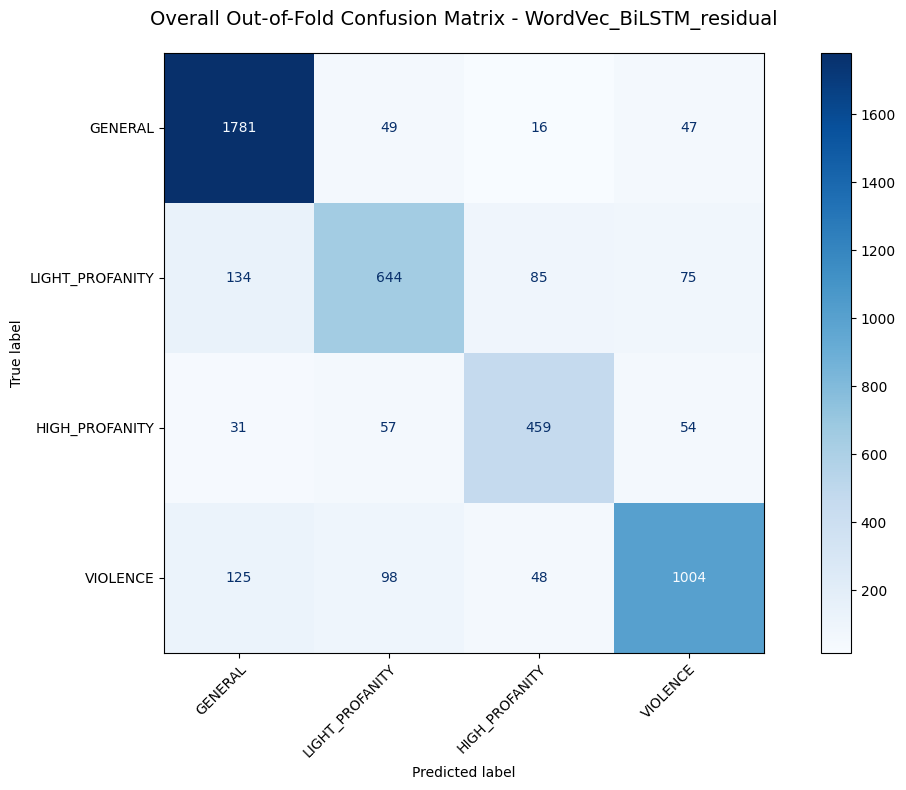

🏃 View run WordVec_BiLSTM_residual at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2/runs/e45bb2e318df4fbba7c54aa4d1be629f
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/2


In [21]:
ResLSTM_cv_outputs = run_cross_validation(architectures_to_test[3], dataset, all_labels, device, label_map, n_splits=5, num_classes=num_classes)